In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..


/home/ck/pythonWorkspace/proj_CEH


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [3]:
def create_dic(dic):
    
    tt = np.array(dic['tmin'])
    mask = np.where(tt<=-50)
    
    pp = np.array(dic['pmax'])[mask]
    sh = np.array(dic['shear'])[mask] #np.array(dic['shear']) * (-1)
    umin = np.array(dic['u650'])[mask]
    umax = np.array(dic['u925'])[mask]
    qq = np.array(dic['q925'])[mask]
    qup = np.array(dic['q650'])[mask]
    tup = np.array(dic['t650'])[mask]
    tlow = np.array(dic['t925'])[mask]
    tt = np.array(dic['tmin'])[mask]
    ttm = np.array(dic['tmean'])[mask]
    month = np.array(dic['month'])[mask]
    area = np.array(dic['area'])[mask]
    lat = np.array(dic['clat'])[mask]
    lon = np.array(dic['clon'])[mask]
    tcwv = np.array(dic['tcwv'])[mask]
    tgrad = np.array(dic['tgrad'])[mask]
    tbox = np.array(dic['tbox'])[mask]
    rh = np.array(dic['rh925'])[mask]
    pall = np.array(dic['p'])[mask]
    
    
    p = units.Quantity(650, 'hPa')
    t = units.Quantity(tup, 'K')
    
    thetaes_up = np.array(calc.saturation_equivalent_potential_temperature(p,t))-273.15
    #thetae_up = u_met.theta_e(650, tup-273.15, qup)


    thetae_down_man = u_met.theta_e(925, tlow-273.15, qq)

    p = units.Quantity(925, 'hPa')
    t = units.Quantity(tlow, 'K')
    q = units.Quantity(qq, 'kg/kg')
    thetaes_down = np.array(calc.saturation_equivalent_potential_temperature(p,t))-273.15
    dew = calc.dewpoint_from_specific_humidity(q, t, p)
    thetae_down = np.array(calc.equivalent_potential_temperature(p,t,dew))-273.15
   
    thetae = thetae_down - thetaes_up
    thetaes = thetaes_down - thetaes_up
    
#     qdef = u_met.qdeficit(qq, tup, 650)
    
    #ipdb.set_trace()
    
    if tgrad.ndim == 2:
        tgrad = tlow
    if tbox.ndim == 2:
        tbox = tlow   ############## this is just to deal with tbox error

    obs_pcp = {
        'prcp' : pp,
        #'u650' : umin,
        #'u925' : umax,
        'q925' : qq*1000,
        'q650' : qup*1000,
        't925' : tlow-273.15,
        'pall' : pall,
        #'t650' : tup-273.15,
        'shear' : sh*-1,
        'month' : month,        
        'area' : (area)*(5**2),
        'tmin' : tt,
        'rh' : rh,
        #'tmean' : ttm,
        #'theta' : theta,
        'theta_e' : thetae,
        'theta_es' : thetaes,
        #'thup' : thetae_up,
        #'thdown' : thetae_down,
        'tcwv' : tcwv,
        'tgrad' : tgrad.squeeze(),
        'tbox' : tbox.squeeze(),
        'lat' : lat,
        'lon' : lon,
    } 
    
    obs = pd.DataFrame(obs_pcp)
    return obs

In [4]:
def create_dic_model(dic):
    
    pp = np.array(dic['pmax'])
    sh = np.array(dic['shearmin']) #np.array(dic['shear']) * (-1)
    umin = np.array(dic['umin_mid'])
    umax = np.array(dic['umax_srfc'])
    qq = np.array(dic['qmax']) #+ 0.5
    tup = np.array(dic['tmidmax'])
    tcwv = np.array(dic['tcwv'])
    tgrad = np.array(dic['tgrad'])
    tbox = np.array(dic['tdiff'])
    tt = np.array(dic['tmin'])
    ttm = np.array(dic['tmean'])
    month = np.array(dic['month'])
    tsrfc = np.array(dic['tsrfcmax']) #+ 3
    area = np.array(dic['area'])
    lat = np.array(dic['clat'])
    lon = np.array(dic['clon'])
    pall = np.array(dic['p'])

    p = units.Quantity(650, 'hPa')
    t = units.Quantity(tup+273.15, 'K')
    
    thetaes_up = np.array(calc.saturation_equivalent_potential_temperature(p,t))
    
#     thetaes_up = []
#     ipdb.set_trace()
#     for tl in t:
#         try:
#             thetaa = float(np.array(calc.saturation_equivalent_potential_temperature(p,tl)))
#             thetaes_up.append(thetaa)
#             ipdb.set_trace()
#         except:
#             thetaes_up.append(np.nan)

    thetaes_up = np.array(thetaes_up)

    p = units.Quantity(925, 'hPa')
    t = units.Quantity(tsrfc+273.15, 'K')
    q = units.Quantity(qq/1000, 'kg/kg')
    thetaes_down = np.array(calc.saturation_equivalent_potential_temperature(p,t))
    dew = calc.dewpoint_from_specific_humidity(q, t, p)
    thetae_down = np.array(calc.equivalent_potential_temperature(p,t,dew))
    
#     thetaes_down = []

#     for tl in t:
#         try:
#             thetaee = float(np.array(calc.saturation_equivalent_potential_temperature(p,tl)))
            
#             thetaes_down.append(thetaee)    
#         except:
#             thetaes_down.append(np.nan) 

#     thetaes_down = np.array(thetaes_down)  
    
    thetaes = thetaes_down-thetaes_up  
    thetae = thetae_down -thetaes_up  
#     qdef = u_met.qdeficit(qq/1000, tup+273.15, 650)
    
    try:
        thetamax = np.array(dic['thetamax'])
        thetamean = np.array(dic['thetamean'])   
    except:
        pass

    obs_pcp = {
        'prcp' : pp,
        'pall' : pall,
        #'u650' : umin,
        #'u925' : umax,
        'q925' : qq,
        't925' : tsrfc,
        'tcwv' : tcwv,
        'tgrad' : tgrad,
        'tbox' : tbox,
        'shear' : sh*-1,
        'month' : month,
        'area' : (area)*(4.4**2),
        'tmin' : tt,
        'tmean' : ttm,
        'lat' : lat,
        'lon' : lon,
        'theta_es' : thetaes
    } 

#     try:
    obs_pcp['theta_e']=thetae #+4
#         #obs_pcp['thetamean']=thetamean
#     except:
#         pass
    
    obs = pd.DataFrame(obs_pcp)
    return obs

In [5]:
ttag = 'monthly'
if ttag=='hourly':
    rres = 'means'
else:
    rres = '0.7deg'
cp4_histf = ('modelhist', cnst.CLOVER_SAVES + 'bulk_-50_5000km2_CP4'+rres+'_'+ttag+'_SAHEL_15kmprecip_WA_5-20N_-50C_TCWV_hist_*.p')
cp4_futf = ('modelfut' , cnst.CLOVER_SAVES + 'bulk_-50_5000km2_CP4'+rres+'_'+ttag+'_SAHEL_15kmprecip_WA_5-20N_-50C_TCWV_fut_*.p')
gpmf = ('obs' , cnst.CLOVER_SAVES + 'bulk_-50_5000km2_GPM_5-26N_16W17E_p15_ERA0.7_TCWV_'+ttag+'_*.p')
dlist = [cp4_histf,cp4_futf,gpmf]

In [6]:
for d in dlist:
    
    #ipdb.set_trace()
    ds = glob.glob(d[1])
    
    
    
    for ids, dss in enumerate(ds):
        data = pkl.load( open (dss, 'rb'))
        #data.update(dat)
        
        if 'model' in d[0]:
            if d[0] == 'modelhist':
                cp4_h = create_dic_model(data)
                if ids > 0:
                    histf = pd.concat([histf, cp4_h])
                else:
                    histf = cp4_h    
            else:
                cp4_f = create_dic_model(data)
                if ids > 0:
                    futf = pd.concat([futf, cp4_f])
                else:
                    futf = cp4_f
        if 'obs' in d[0]:
            if d[0] == 'obsm':
                obs_gpmc_m = create_dic(data)
                if ids > 0:
                    obs_gpmc = pd.concat([obs_gpmc, obs_gpmc_m])
                else:
                    obs_gpmc = obs_gpmc_m
            else:
                obs_gpmf_h = create_dic(data)
                if ids > 0:
                    obs_gpmf = pd.concat([obs_gpmf, obs_gpmf_h])
                else:
                    obs_gpmf = obs_gpmf_h
                    

        del data

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/ck/miniconda3/lib/python3.7/site-packages/metpy/calc/thermo.py:828: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [7]:
obs_gpmf.head()

,prcp,q925,q650,t925,pall,shear,month,area,tmin,rh,theta_e,theta_es,tcwv,tgrad,tbox,lat,lon
0,37.272179,14.910911,5.850761,26.145251,"[0.15179347255043746, 0.02247781958940777, 0.0...",12.507494,5,6025,-89.861326,65.399376,7.413128,34.120030,46.146538,299.295251,299.295251,9.107030,4.267612
1,11.890529,14.456284,6.234189,22.879093,"[0.2098612655895912, 0.298261813798935, 0.3401...",8.875172,8,19375,-71.728925,76.773526,2.354757,16.563300,45.954697,296.029093,296.029093,10.055397,-9.405499
2,6.647016,15.655881,5.492429,24.096507,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",15.023509,8,23525,-76.937818,77.253547,5.411784,20.701025,46.039680,297.246507,297.246507,12.796698,-7.665718
3,26.613995,15.766182,5.411600,26.484633,"[0.12639732582784705, 0.8429170014806432, 0.82...",17.039546,8,14275,-83.129719,67.849238,6.846807,32.509345,45.104015,299.634633,299.634633,16.598810,-3.755964
4,0.867043,15.059730,6.125930,25.044596,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",14.294279,8,249475,-57.151272,70.458619,5.882608,27.075479,46.079224,298.194596,298.194596,11.147133,8.439040


In [8]:
futf['theta_e']

0       -2.468157
1        0.150188
2       -6.342441
3      -10.192493
4      -12.633843
          ...    
6168     7.912494
6169    10.743655
6170    10.211679
6171    10.227064
6172     7.006459
Name: theta_e, Length: 51565, dtype: float64

In [9]:
print(np.max(obs_gpmf.lat))
print(np.min(obs_gpmf.lat))
print(np.max(obs_gpmf.lon))
print(np.min(obs_gpmf.lon))

17.824957782145926
9.000161827841007
12.107882421128927
-14.99856490789569


In [10]:
tag = 'Sahel'
domainSA = [-10,12,5,8.5]
domainSS = [-14,12,9,18]  # 8.5, 17.5
domainWA = [-10,12,5,17.5]
domainOuaga = [-3.5,2,11,13.5]
nb = 25
region = {'Sahel' : [domainSS, 'SoudanoSahel', np.linspace(9.5,17.8,nb) , np.linspace(5,21,nb), np.linspace(-7.9,7.9,nb), np.linspace(29,75,nb)],  #np.linspace(10,17.5,17) , np.linspace(0,25,17)  # monthly tcwv 30-50
          'Ouaga' : [domainOuaga, 'Ouaga', np.linspace(9.5,17.8,nb) , np.linspace(6,20,nb), np.linspace(-7.9,7.9,nb), np.linspace(29,80,nb)],
          'WA' : [domainWA, 'fullWA', np.linspace(11.5,19.5,nb), np.linspace(3,27,nb), np.linspace(-7.9,6,nb), np.linspace(20,92,nb)],
          'SWA' : [domainSA, 'southernWA', np.linspace(12.8,17.5,nb), np.linspace(0,25,nb), np.linspace(-7.9,7.9,nb), np.linspace(20,92,nb)],
         }

domain = region[tag][0]
tname = region[tag][1]
qbins = region[tag][2]
shearbins = region[tag][3]
thetabins = region[tag][4]
tcwvbins=region[tag][5]
qshearbins = qbins*shearbins

m1 = 5 #5
m2 = 10 #10
obs_gpm = obs_gpmf[(obs_gpmf.lon>=domain[0])&(obs_gpmf.lon<=domain[1])&(obs_gpmf.lat>=domain[2])&(obs_gpmf.lat<=domain[3])& (obs_gpmf.month>=m1) & (obs_gpmf.month<=m2)] #& (obs_gpm.month!=6) & (obs_gpm.month!=9)]
hist = histf[(histf.lon>=domain[0])&(histf.lon<=domain[1])&(histf.lat>=domain[2])&(histf.lat<=domain[3])& (histf.month>=m1) & (histf.month<=m2)]# & (histf.tbox<=10)]
fut = futf[(futf.lon>=domain[0])&(futf.lon<=domain[1])&(futf.lat>=domain[2])&(futf.lat<=domain[3])& (futf.month>=m1) & (futf.month<=m2)]# & (futf.tbox<=10)]


In [11]:
print('hist', hist.lat.min(), hist.lat.max(), hist.lon.min(), hist.lon.max())
print('OBS_gpm', obs_gpm.lat.min(), obs_gpm.lat.max(), obs_gpm.lon.min(), obs_gpm.lon.max())

hist 9.008251190185547 17.99925422668457 -11.76275634765625 11.990509033203125
OBS_gpm 9.000161827841007 17.76619979135581 -13.999891917987835 11.9997069672409


In [12]:
len(obs_gpm)

45687

In [13]:
np.median(hist['shear'])

16.56977

In [14]:
np.median(fut['shear'])

17.16146

In [15]:
np.mean(fut['t925'])-np.mean(hist['t925'])

5.410325762968117

In [16]:
(np.mean(fut['q925'])-np.mean(hist['q925']))/np.mean(hist['q925'])  / (np.mean(fut['t925'])-np.mean(hist['t925']))   ### CC scaling with q925 in CP4 is ~ 0.062

0.06156808670155685

In [17]:
(np.mean(fut['tcwv'])-np.mean(hist['tcwv']))/np.mean(hist['tcwv'])  / (np.mean(fut['t925'])-np.mean(hist['t925']))   ### CC scaling in CP4 is ~ 0.062 

0.08381466309159685

In [18]:
 np.mean(fut['t925'])-np.mean(hist['t925'])

5.410325762968117

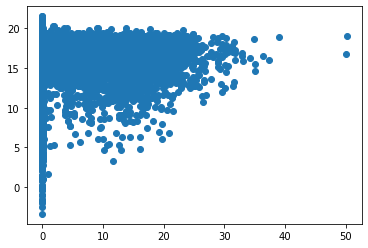

In [19]:
plt.scatter(hist.tgrad, hist.shear)

Text(0.5, 1.0, '-0.57')

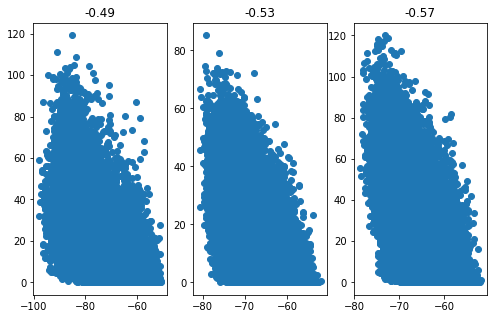

In [20]:

cp4s = [obs_gpm.tmin, obs_gpm.prcp] # gpm
cp25s = [hist.tmin, hist.prcp] #cp4
futur = [fut.tmin, fut.prcp] 


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(141)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(142)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(143)
plt.scatter(futur[0],futur[1])
r = stats.pearsonr(futur[0],futur[1])
plt.title(str(np.round(r[0], decimals=2)))





Text(0.5, 1.0, '-0.79')

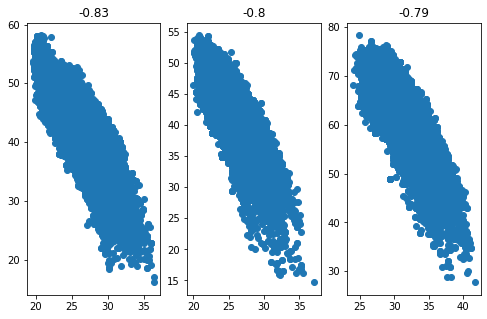

In [21]:

cp4s = [obs_gpm.t925, obs_gpm.tcwv] # gpm
cp25s = [hist.t925, hist.tcwv] #cp4
futur = [fut.t925, fut.tcwv] #cp4


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(141)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(142)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

ax = f.add_subplot(143)
plt.scatter(futur[0],futur[1])
r = stats.pearsonr(futur[0],futur[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

In [22]:
def density_plot(v1,v2):
    xy = np.vstack([v1, v2])
    z = gaussian_kde(xy)(xy)
    data = z / (z.max() - z.min())

#     rr = stats.pearsonr(v1,v2)
#     print('pears', stats.pearsonr(v1,v2))
    
    return data

In [23]:
oposi =  (obs_gpm.q925>=8.) & (obs_gpm.prcp>=5) & (obs_gpm.theta_e>=-40) & (obs_gpm.area>=5000) & (obs_gpm.shear>0) & (obs_gpm.tmin<=-55)  # & ((obs_gpm.month>=9) | (obs_gpm.month<=5)) #(obs_gpm.q925>=9.) & (obs_gpm.shear>-5) & 
cposi =   (hist.q925>=8.) &(hist.prcp>=5)  & (hist.theta_e>=-40) & (np.isfinite(hist.q925)) & (hist.shear>0)  & (hist.area>=5000) & (hist.tmin<=-55)  #(hist.q925>=9.) & (hist.shear>-5) &
fposi =  (fut.q925>=8.) &(fut.prcp>=5)  & (fut.theta_e>=-40) & (np.isfinite(fut.q925)) & (fut.shear>0)  & (fut.area>=5000) & (fut.tmin<=-55)   #(fut.q925>=9.) & (fut.shear>-5) & 

In [24]:
obs = obs_gpm[oposi]
cp4 = hist[cposi]
cp4f = fut[fposi]
cp4.area = cp4.area.values

/home/ck/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [25]:
np.percentile(obs['tcwv'],0.01)

24.59458685245514

In [26]:
np.percentile(cp4['tcwv'],0.01)

24.159795566940307

In [27]:
cp4.area.min()

5014.240000000001

In [28]:
(np.mean(cp4f['tcwv'])-np.mean(cp4['tcwv']))/np.mean(cp4['tcwv'])  / (np.mean(cp4f['t925'])-np.mean(cp4['t925']))   ### CC scaling in CP4 is ~ 0.062

0.08302301830334939

In [29]:
np.mean(cp4f['t925'])-np.mean(cp4['t925'])

5.428362992040487

In [30]:
np.mean(cp4['t925'])

25.586739175616568

In [31]:
np.mean(cp4f['q925'][cp4f['prcp']>15])-np.mean(cp4['q925'][cp4['prcp']>15])

4.643303987957182

In [32]:
obs.area.min()

5225

In [33]:
len(obs)

39044

In [34]:
len(cp4)

46450

In [35]:
len(cp4f)

35986

In [36]:
print(np.mean(cp4.shear))

16.085451126098633


In [37]:
print(np.mean(cp4f.shear))

16.544008255004883


In [38]:
out_cp4 = {}
out_cp4f = {}

for k in ['prcp','tcwv', 'shear', 'tgrad']:
    out_cp4[k] = cp4[k]
    out_cp4f[k] = cp4f[k]

In [39]:
cp4f_csv = pd.DataFrame.from_dict(out_cp4f)
cp4_csv = pd.DataFrame.from_dict(out_cp4)

In [40]:
# cp4f_csv.to_csv('/home/ck/DIR/cornkle/figs/ENDGAME/cp4_csv/cp4f.csv')
# cp4_csv.to_csv('/home/ck/DIR/cornkle/figs/ENDGAME/cp4_csv/cp4.csv')

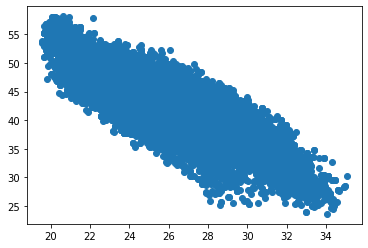

In [41]:
plt.scatter(obs['t925'], obs['tcwv'])

In [42]:
np.min(obs['tcwv'])

23.635562896728516

In [43]:
len(cp4f['tcwv'])

35986

In [44]:
len(cp4['tcwv'])

46450

In [45]:
cp4f['tcwv']-cp4['tcwv']

149    NaN
150    NaN
151    NaN
152    NaN
153    NaN
        ..
7753   NaN
7754   NaN
7756   NaN
7757   NaN
7758   NaN
Name: tcwv, Length: 249718, dtype: float32

In [46]:
obs_basic = hist2d.basic_1d_binning(obs['tcwv'], np.arange(np.min(obs['tcwv']), np.max(obs['tcwv']),1))
cp4_basic = hist2d.basic_1d_binning(cp4['tcwv'], np.arange(np.min(cp4['tcwv']), np.max(cp4['tcwv']),1))
cp4f_basic = hist2d.basic_1d_binning(cp4f['tcwv'], np.arange(np.min(cp4f['tcwv']), np.max(cp4f['tcwv']),1))

In [47]:
obs_basic_shear = hist2d.basic_1d_binning(obs['shear'], np.arange(np.min(obs['shear']), np.max(obs['shear']),1))
cp4_basic_shear = hist2d.basic_1d_binning(cp4['shear'], np.arange(np.min(cp4['shear']), np.max(cp4['shear']),1))
cp4f_basic_shear = hist2d.basic_1d_binning(cp4f['shear'], np.arange(np.min(cp4f['shear']), np.max(cp4f['shear']),1))

In [60]:
obs_basic_pr = hist2d.basic_1d_binning(obs['prcp'], np.arange(np.min(obs['prcp']), np.max(obs['prcp']),1))
cp4_basic_pr = hist2d.basic_1d_binning(cp4['prcp'], np.arange(np.min(cp4['prcp']), np.max(cp4['prcp']),1))
cp4f_basic_pr = hist2d.basic_1d_binning(cp4f['prcp'], np.arange(np.min(cp4f['prcp']), np.max(cp4f['prcp']),1))

In [138]:
high = (obs['prcp'])[(obs['lat']>16) & (obs['lat']<19)]
mid = (obs['prcp'])[(obs['lat']<16)&(obs['lat']>12)]
low = (obs['prcp'])[(obs['lat']>9)&(obs['lat']<12)]

hight = (obs['tcwv'])[(obs['lat']>16) & (obs['lat']<19)]
midt = (obs['tcwv'])[(obs['lat']<16)&(obs['lat']>12)]
lowt = (obs['tcwv'])[(obs['lat']>9)&(obs['lat']<12)]

highs = (obs['shear'])[(obs['lat']>16) & (obs['lat']<19)]
mids = (obs['shear'])[(obs['lat']<16)&(obs['lat']>12)]
lows = (obs['shear'])[(obs['lat']>9)&(obs['lat']<12)]

cp4_high = hist2d.basic_1d_binning(high, np.arange(5, 90,1))
cp4_mid = hist2d.basic_1d_binning(mid, np.arange(5, 90,1))
cp4_low = hist2d.basic_1d_binning(low, np.arange(5, 90,1))

cp4_hight = hist2d.basic_1d_binning(hight, np.arange(5, 90,1))
cp4_midt = hist2d.basic_1d_binning(midt, np.arange(5, 90,1))
cp4_lowt = hist2d.basic_1d_binning(lowt, np.arange(5, 90,1))

cp4_highs = hist2d.basic_1d_binning(highs, np.arange(5, 90,1))
cp4_mids = hist2d.basic_1d_binning(mids, np.arange(5, 90,1))
cp4_lows = hist2d.basic_1d_binning(lows, np.arange(5, 90,1))

p_high = np.percentile(high, np.arange(1,101,5))
p_mid = np.percentile(mid, np.arange(1,101,5))
p_low = np.percentile(low, np.arange(1,101,5))

p_hight = np.percentile(hight, np.arange(1,101,5))
p_midt = np.percentile(midt, np.arange(1,101,5))
p_lowt = np.percentile(lowt, np.arange(1,101,5))

p_highs = np.percentile(highs, np.arange(1,101,5))
p_mids = np.percentile(mids, np.arange(1,101,5))
p_lows = np.percentile(lows, np.arange(1,101,5))

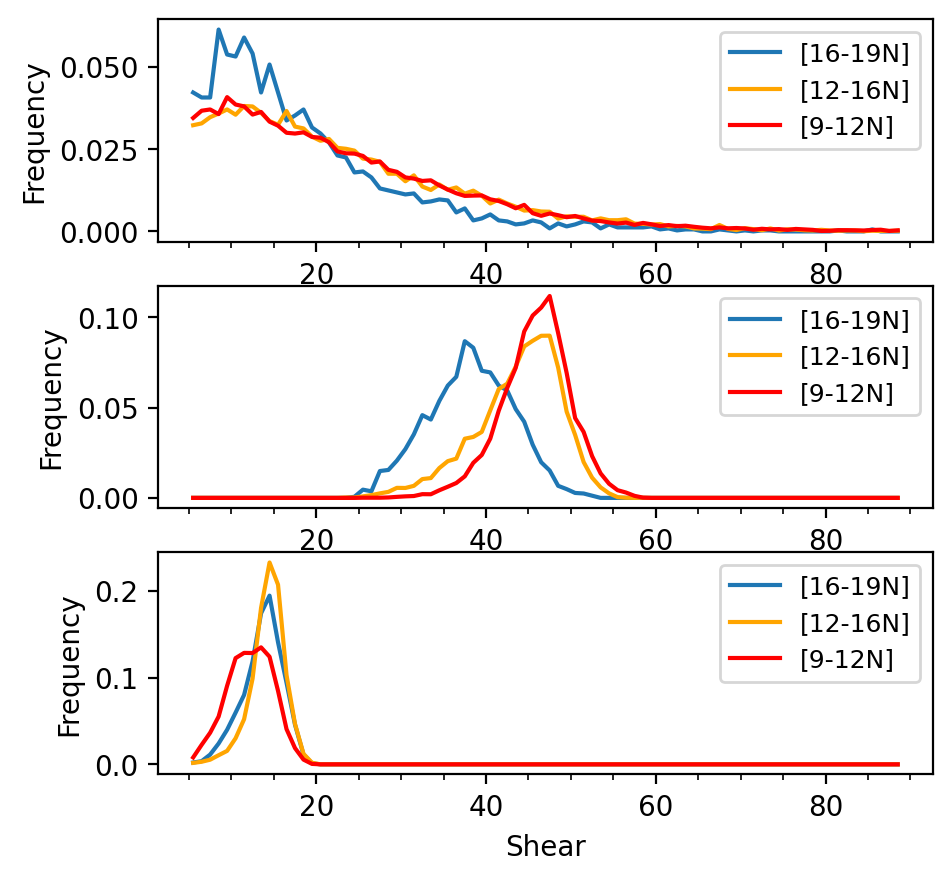

In [139]:
f = plt.figure(figsize=(5,5), dpi=200)
ax = f.add_subplot(311)
plt.plot(cp4_high['xbins'], cp4_high['nb']/np.sum(cp4_high['nb']), label='[16-19N]')
plt.plot(cp4_mid['xbins'], cp4_mid['nb']/np.sum(cp4_mid['nb']), color='orange', label='[12-16N]')
plt.plot(cp4_low['xbins'], cp4_low['nb']/np.sum(cp4_low['nb']), color='red', label='[9-12N]')
plt.ylabel('Frequency')
plt.xlabel('Precip')
plt.legend(loc='upper right', fontsize=9)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor')

ax = f.add_subplot(312)
plt.plot(cp4_hight['xbins'], cp4_hight['nb']/np.sum(cp4_hight['nb']), label='[16-19N]')
plt.plot(cp4_midt['xbins'], cp4_midt['nb']/np.sum(cp4_midt['nb']), color='orange', label='[12-16N]')
plt.plot(cp4_lowt['xbins'], cp4_lowt['nb']/np.sum(cp4_lowt['nb']), color='red', label='[9-12N]')
plt.ylabel('Frequency')
plt.xlabel('TCW')
plt.legend(loc='upper right', fontsize=9)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor')

ax = f.add_subplot(313)
plt.plot(cp4_highs['xbins'], cp4_highs['nb']/np.sum(cp4_highs['nb']), label='[16-19N]')
plt.plot(cp4_mids['xbins'], cp4_mids['nb']/np.sum(cp4_mids['nb']), color='orange', label='[12-16N]')
plt.plot(cp4_lows['xbins'], cp4_lows['nb']/np.sum(cp4_lows['nb']), color='red', label='[9-12N]')
plt.ylabel('Frequency')
plt.xlabel('Shear')
plt.legend(loc='upper right', fontsize=9)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor')

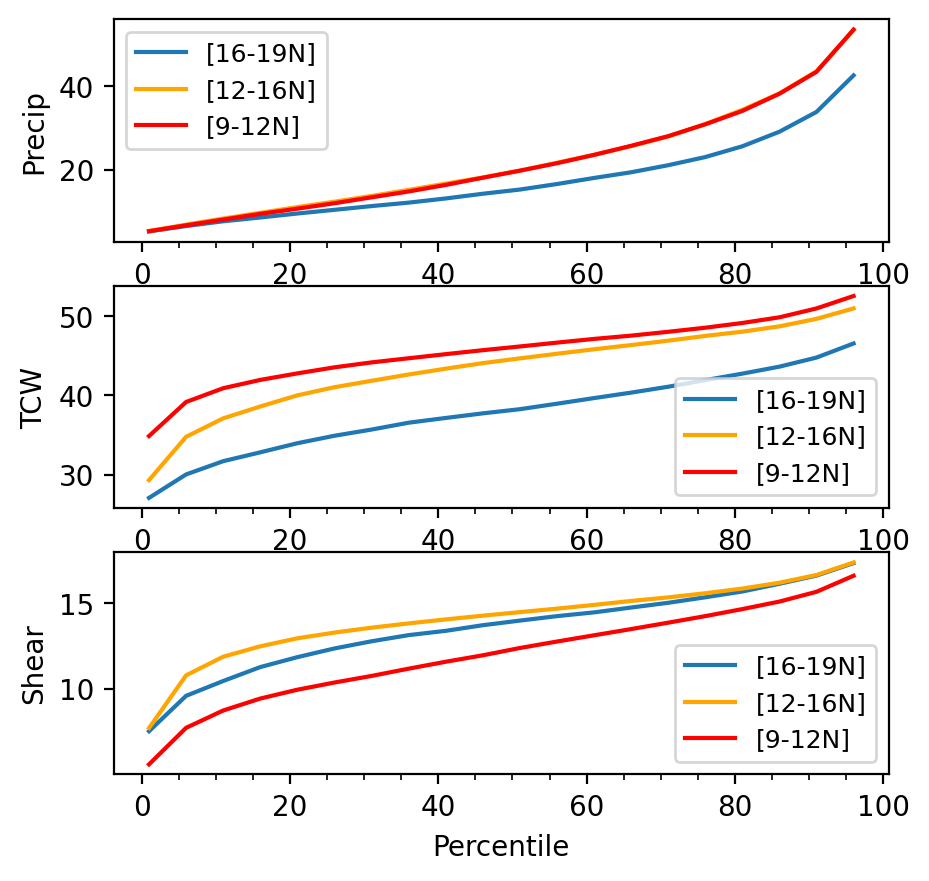

In [141]:
f = plt.figure(figsize=(5,5), dpi=200)
ax = f.add_subplot(311)
plt.plot(np.arange(1,101,5), p_high, label='[16-19N]')
plt.plot(np.arange(1,101,5), p_mid, color='orange', label='[12-16N]')
plt.plot(np.arange(1,101,5), p_low, color='red', label='[9-12N]')
plt.ylabel('Precip')
plt.xlabel('Percentile')
plt.legend(fontsize=9)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor')

ax = f.add_subplot(312)
plt.plot(np.arange(1,101,5), p_hight, label='[16-19N]')
plt.plot(np.arange(1,101,5), p_midt, color='orange', label='[12-16N]')
plt.plot(np.arange(1,101,5), p_lowt, color='red', label='[9-12N]')
plt.ylabel('TCW')
plt.xlabel('Percentile')
plt.legend(fontsize=9)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor')

ax = f.add_subplot(313)
plt.plot(np.arange(1,101,5), p_highs, label='[16-19N]')
plt.plot(np.arange(1,101,5), p_mids, color='orange', label='[12-16N]')
plt.plot(np.arange(1,101,5), p_lows, color='red', label='[9-12N]')
plt.ylabel('Shear')
plt.xlabel('Percentile')
plt.legend(fontsize=9)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor')

In [144]:
var = cp4
high = (var['prcp'])[(var['lat']>16) & (var['lat']<19)]
mid = (var['prcp'])[(var['lat']<16)&(var['lat']>12)]
low = (var['prcp'])[(var['lat']>9)&(var['lat']<12)]

hight = (var['tcwv'])[(var['lat']>16) & (var['lat']<19)]
midt = (var['tcwv'])[(var['lat']<16)&(var['lat']>12)]
lowt = (var['tcwv'])[(var['lat']>9)&(var['lat']<12)]

highs = (var['shear'])[(var['lat']>16) & (var['lat']<19)]
mids = (var['shear'])[(var['lat']<16)&(var['lat']>12)]
lows = (var['shear'])[(var['lat']>9)&(var['lat']<12)]

cp4_high = hist2d.basic_1d_binning(high, np.arange(5, 90,1))
cp4_mid = hist2d.basic_1d_binning(mid, np.arange(5, 90,1))
cp4_low = hist2d.basic_1d_binning(low, np.arange(5, 90,1))

cp4_hight = hist2d.basic_1d_binning(hight, np.arange(5, 90,1))
cp4_midt = hist2d.basic_1d_binning(midt, np.arange(5, 90,1))
cp4_lowt = hist2d.basic_1d_binning(lowt, np.arange(5, 90,1))

cp4_highs = hist2d.basic_1d_binning(highs, np.arange(5, 90,1))
cp4_mids = hist2d.basic_1d_binning(mids, np.arange(5, 90,1))
cp4_lows = hist2d.basic_1d_binning(lows, np.arange(5, 90,1))

p_high = np.percentile(high, np.arange(1,101,5))
p_mid = np.percentile(mid, np.arange(1,101,5))
p_low = np.percentile(low, np.arange(1,101,5))

p_hight = np.percentile(hight, np.arange(1,101,5))
p_midt = np.percentile(midt, np.arange(1,101,5))
p_lowt = np.percentile(lowt, np.arange(1,101,5))

p_highs = np.percentile(highs, np.arange(1,101,5))
p_mids = np.percentile(mids, np.arange(1,101,5))
p_lows = np.percentile(lows, np.arange(1,101,5))

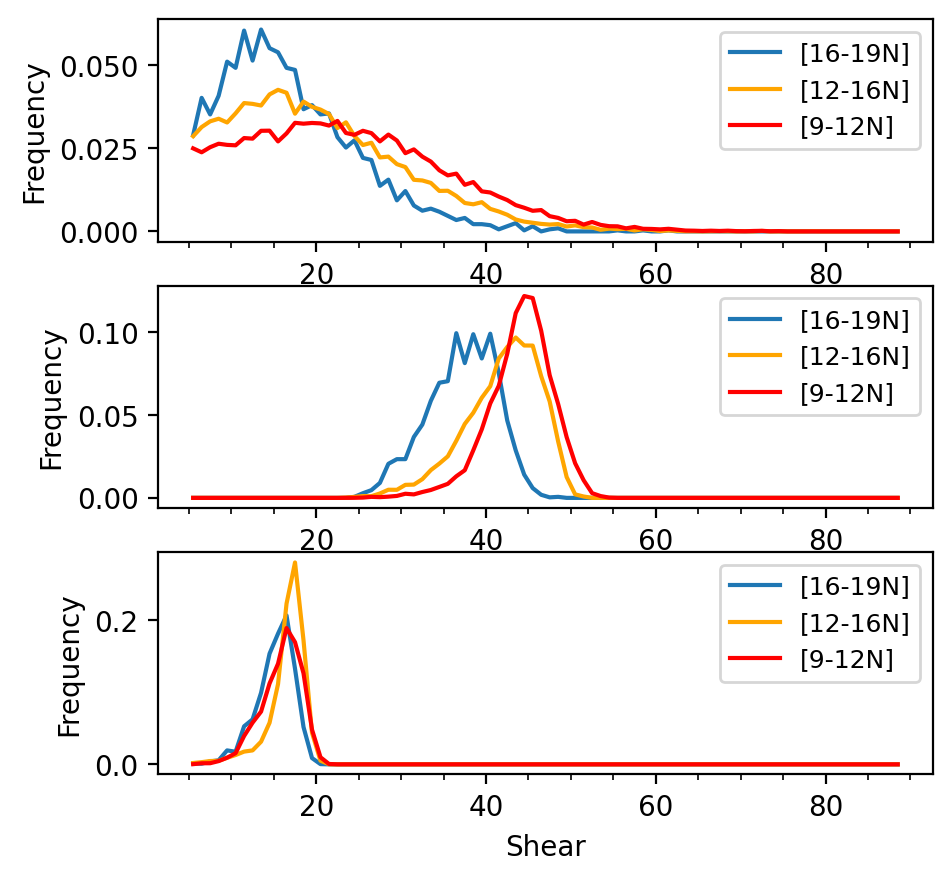

In [145]:
f = plt.figure(figsize=(5,5), dpi=200)
ax = f.add_subplot(311)
plt.plot(cp4_high['xbins'], cp4_high['nb']/np.sum(cp4_high['nb']), label='[16-19N]')
plt.plot(cp4_mid['xbins'], cp4_mid['nb']/np.sum(cp4_mid['nb']), color='orange', label='[12-16N]')
plt.plot(cp4_low['xbins'], cp4_low['nb']/np.sum(cp4_low['nb']), color='red', label='[9-12N]')
plt.ylabel('Frequency')
plt.xlabel('Precip')
plt.legend(loc='upper right', fontsize=9)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor')

ax = f.add_subplot(312)
plt.plot(cp4_hight['xbins'], cp4_hight['nb']/np.sum(cp4_hight['nb']), label='[16-19N]')
plt.plot(cp4_midt['xbins'], cp4_midt['nb']/np.sum(cp4_midt['nb']), color='orange', label='[12-16N]')
plt.plot(cp4_lowt['xbins'], cp4_lowt['nb']/np.sum(cp4_lowt['nb']), color='red', label='[9-12N]')
plt.ylabel('Frequency')
plt.xlabel('TCW')
plt.legend(loc='upper right', fontsize=9)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor')

ax = f.add_subplot(313)
plt.plot(cp4_highs['xbins'], cp4_highs['nb']/np.sum(cp4_highs['nb']), label='[16-19N]')
plt.plot(cp4_mids['xbins'], cp4_mids['nb']/np.sum(cp4_mids['nb']), color='orange', label='[12-16N]')
plt.plot(cp4_lows['xbins'], cp4_lows['nb']/np.sum(cp4_lows['nb']), color='red', label='[9-12N]')
plt.ylabel('Frequency')
plt.xlabel('Shear')
plt.legend(loc='upper right', fontsize=9)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor')

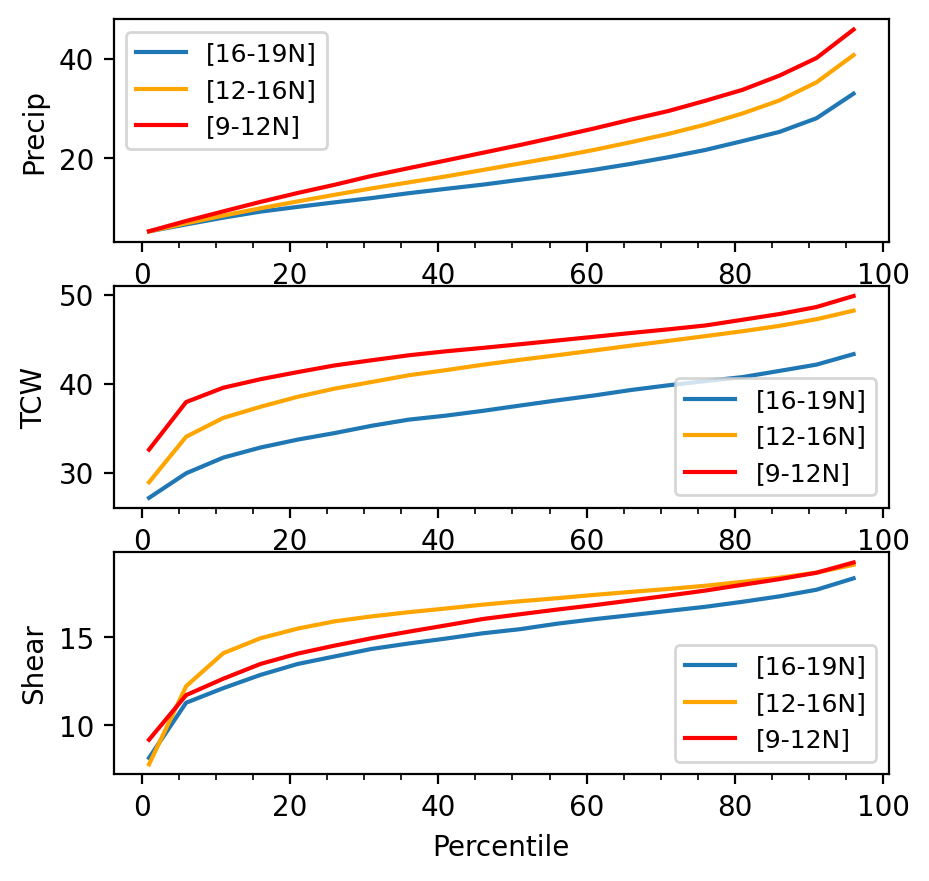

In [146]:
f = plt.figure(figsize=(5,5), dpi=200)
ax = f.add_subplot(311)
plt.plot(np.arange(1,101,5), p_high, label='[16-19N]')
plt.plot(np.arange(1,101,5), p_mid, color='orange', label='[12-16N]')
plt.plot(np.arange(1,101,5), p_low, color='red', label='[9-12N]')
plt.ylabel('Precip')
plt.xlabel('Percentile')
plt.legend(fontsize=9)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor')

ax = f.add_subplot(312)
plt.plot(np.arange(1,101,5), p_hight, label='[16-19N]')
plt.plot(np.arange(1,101,5), p_midt, color='orange', label='[12-16N]')
plt.plot(np.arange(1,101,5), p_lowt, color='red', label='[9-12N]')
plt.ylabel('TCW')
plt.xlabel('Percentile')
plt.legend(fontsize=9)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor')

ax = f.add_subplot(313)
plt.plot(np.arange(1,101,5), p_highs, label='[16-19N]')
plt.plot(np.arange(1,101,5), p_mids, color='orange', label='[12-16N]')
plt.plot(np.arange(1,101,5), p_lows, color='red', label='[9-12N]')
plt.ylabel('Shear')
plt.xlabel('Percentile')
plt.legend(fontsize=9)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor')

In [49]:
hmean = []
for pp in cp4['prcp']:
    if np.sum(pp) < 5:
        continue
    hmean.append(np.nanmax(pp))
fmean = []
for pp in cp4f['prcp']:
    if np.sum(pp) < 5:
        continue
    fmean.append(np.nanmax(pp))

In [50]:
fp = np.percentile(fmean,50)
print(fp)
print(stats.percentileofscore(hmean, fp))

31.098652980922004
80.7491926803014


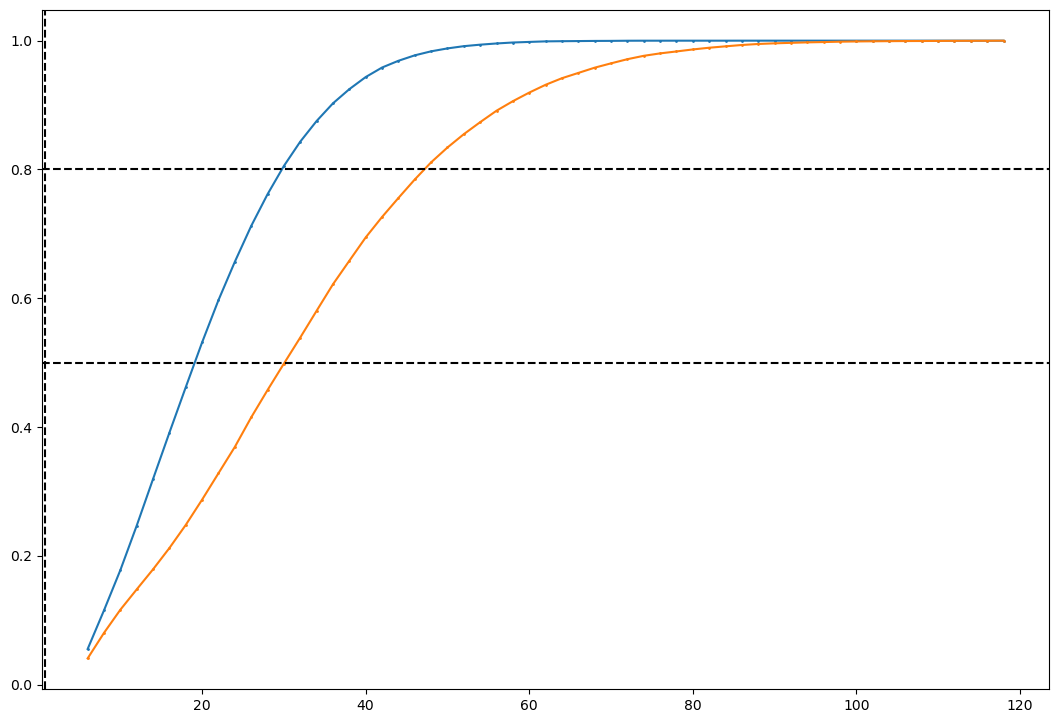

In [51]:
f = plt.figure(figsize=(13,9), dpi=100)
ax = f.add_subplot(111)
#ipdb.set_trace()
nball, allcount, bins = u_stat.histo_frequency(hmean, bins=np.arange(5, 120, 2))
#ipdb.set_trace()
bin_centre = bins[0:-1] + ((bins[1::] - bins[0:-1]) / 2)
cumulative = np.cumsum(nball)
ax.plot(bin_centre,cumulative, marker='o', markersize=1)

#ipdb.set_trace()
nball, allcount, bins = u_stat.histo_frequency(fmean, bins=np.arange(5, 120, 2))
#ipdb.set_trace()
bin_centre = bins[0:-1] + ((bins[1::] - bins[0:-1]) / 2)
cumulative = np.cumsum(nball)
ax.plot(bin_centre,cumulative,  marker='o', markersize=1)
plt.axhline(0.5, linestyle='dashed', color='k')
plt.axhline(0.8, linestyle='dashed', color='k')
plt.axvline(0.8, linestyle='dashed', color='k')

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide


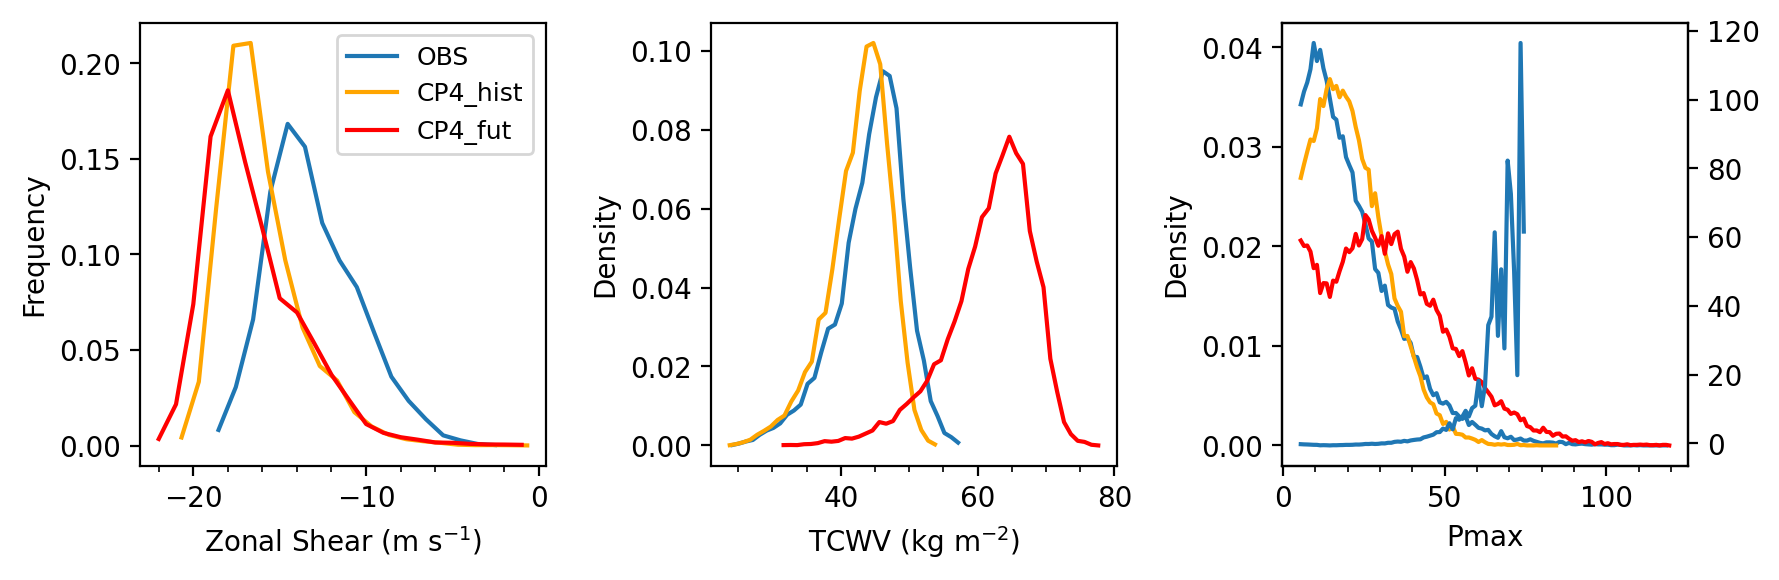

In [101]:
f = plt.figure(figsize=(9,3), dpi=200)
ax = f.add_subplot(131)
plt.plot(obs_basic_shear['xbins']*(-1), obs_basic_shear['nb']/np.sum(obs_basic_shear['nb']), label='OBS')
plt.plot(cp4_basic_shear['xbins']*(-1), cp4_basic_shear['nb']/np.sum(cp4_basic_shear['nb']), color='orange', label='CP4_hist')
plt.plot(cp4f_basic_shear['xbins']*(-1), cp4f_basic_shear['nb']/np.sum(cp4f_basic_shear['nb']), color='red', label='CP4_fut')
plt.ylabel('Frequency')
plt.xlabel('Zonal Shear (m s$^{-1}$)')
plt.legend(loc='upper right', fontsize=9)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor')
# for xx in range(5,26,5):
#     plt.axvline(xx, linestyle='dashed', color='slategrey', linewidth=0.5)
ax = f.add_subplot(132)
plt.plot(obs_basic['xbins'], obs_basic['nb']/np.sum(obs_basic['nb']), label='OBS')
plt.plot(cp4_basic['xbins'], cp4_basic['nb']/np.sum(cp4_basic['nb']), color='orange', label='CP4_hist')
plt.plot(cp4f_basic['xbins'], cp4f_basic['nb']/np.sum(cp4f_basic['nb']), color='red', label='CP4_fut')
plt.ylabel('Density')
plt.xlabel('TCWV (kg m$^{-2}$)')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor')

ax = f.add_subplot(133)
plt.plot(obs_basic_pr['xbins'], obs_basic_pr['nb']/np.sum(obs_basic_pr['nb']), label='OBS')
plt.plot(cp4_basic_pr['xbins'], cp4_basic_pr['nb']/np.sum(cp4_basic_pr['nb']), color='orange', label='CP4_hist')
plt.plot(cp4f_basic_pr['xbins'], cp4f_basic_pr['nb']/np.sum(cp4f_basic_pr['nb']), color='red', label='CP4_fut')
plt.ylabel('Density')
plt.xlabel('Pmax')
ax1 = ax.twinx()
ax1.plot(cp4_basic_pr['xbins'], (np.array(cp4f_basic_pr['nb']/np.sum(cp4f_basic_pr['nb']))[0:80]-(cp4_basic_pr['nb']/np.sum(cp4_basic_pr['nb'])))/(cp4_basic_pr['nb']/np.sum(cp4_basic_pr['nb'])))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor')

#plt.xlim(19,80)
plt.tight_layout()
#plt.savefig(cnst.network_data + 'figs/ENDGAME/distribution_'+tag+'_OBS_CP4_driver_'+ttag+'_percentile.png')

In [102]:

print('Average shear change ABS', np.percentile(cp4f['shear'],50)-np.percentile(cp4['shear'],50))
print('Average shear change REL', (np.median(cp4f['shear'])-np.median(cp4['shear']))/np.median(cp4['shear']))

Average shear change ABS 0.5963459014892578
Average shear change REL 0.035971407


In [103]:
print('Average tcwv change ABS', np.median(cp4f['tcwv'])-np.median(cp4['tcwv']))
print('Average shear change REL', (np.mean(cp4f['tcwv'])-np.mean(cp4['tcwv']))/np.mean(cp4['tcwv']))

Average tcwv change ABS 19.601448
Average shear change REL 0.4506790800454018


In [104]:
print('Average tcwv change ABS', np.array(cp4f['tcwv']).size-np.array(cp4['tcwv']).size)
print('Average shear change REL', (np.array(cp4f['tcwv']).size-np.array(cp4['tcwv']).size)/np.array(cp4['tcwv']).size)

Average tcwv change ABS -10464
Average shear change REL -0.22527448869752423


In [105]:
print(np.median(obs['shear']))
print(np.median(cp4['shear']))
print(np.median(cp4f['shear']))

13.447504088255528
16.578331
17.174677


In [106]:
p = 90
np.percentile(cp4['prcp'][cp4['prcp']>0],p)

36.81874639598122

In [107]:
np.percentile(cp4f['prcp'][cp4f['prcp']>0],p)

58.19606932979068

In [108]:
(np.percentile(cp4f['prcp'][cp4f['prcp']>0],p)-np.percentile(cp4['prcp'][cp4['prcp']>0],p))/np.percentile(cp4['prcp'][cp4['prcp']>0],p)

0.580609744392134

In [109]:
def read_all(isdata, rainthresh):
    isdata = np.concatenate(np.array(isdata), axis=0)
    isdata = isdata[isdata>rainthresh]
    return isdata

cp4all = np.mean(read_all(cp4['pall'],1))
cp4fall = np.mean(read_all(cp4f['pall'],1))

In [110]:
cp4all

7.229935057220458

In [111]:
cp4fall

9.5641126863854

In [112]:
def hist2d_quatro(data, valid=False):
    f = plt.figure(figsize=(10,7))
    
    for i, dat in enumerate(data):
        if (i==2) | (i==3):
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
            
        ax = f.add_subplot(2,2,i+1)
      
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
#         if valid:
            
#             dat['data'][dat['valid']<5] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_facecolor('xkcd:grey')
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],11)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 
    #plt.savefig(cnst.network_data + 'figs/CLOVER/OBS_CP4_2dHist_SoudanoSahel_15km_thetae_shear.png')

In [113]:
def hist2d_six_area(data, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(15,8))
    for i, dat in enumerate(data):
        
        print(i)
        ax = f.add_subplot(2,3,i+1)
        if i in [0,1]:
            cmap = 'Reds_r'
            
        if i in [3,4]:
            cmap = 'Blues'
        if i in[2,5]:
            cmap = 'Purples'
            
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(12, base_cmap=cmap)
#         if valid:
            
#             dat['data'][dat['valid']<5] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_facecolor('xkcd:grey')
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],13)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 
    #plt.savefig(cnst.network_data + 'figs/ENDGAME/OBS_CP4_2dHist_'+tag+'_15km_future_50C.png')

In [114]:
vlist = ['prcp', 'area', 'tmin'] # place to change precip input

In [115]:
def get_percentile(x, ttag):
    
    if ttag == 'hourly':
        ptag = [0.05]+list(np.arange(5,96,5))+[99.95]
    else:
        ptag =  [0.5]+list(np.arange(5,96,5))+[99.5]
                         
    return np.percentile(x[np.isfinite(x)], ptag) 

In [116]:
# obs_q925 = hist2d.create_2dhist(obs.shear, obs.q925, get_percentile(obs.shear), get_percentile(obs.q925), obs, vlist)
# obs_theta = hist2d.create_2dhist(obs.shear, obs.theta_e, get_percentile(obs.shear), get_percentile(obs.theta_e), obs, vlist)
# obs_tcwv = hist2d.create_2dhist(obs.shear, obs.tcwv, get_percentile(obs.shear), get_percentile(obs.tcwv), obs, vlist)

# cp4_q925 = hist2d.create_2dhist(cp4.shear, cp4.q925, get_percentile(cp4.shear), get_percentile(cp4.q925), cp4, vlist)
# cp4_theta = hist2d.create_2dhist(cp4.shear, cp4.theta_e,get_percentile(cp4.shear), get_percentile(cp4.theta_e), cp4, vlist)
# cp4_tcwv = hist2d.create_2dhist(cp4.shear, cp4.tcwv, get_percentile(cp4.shear), get_percentile(cp4.tcwv), cp4, vlist)

# cp4f_q925 = hist2d.create_2dhist(cp4f.shear, cp4f.q925, get_percentile(cp4f.shear), get_percentile(cp4f.q925), cp4f, vlist)
# cp4f_theta = hist2d.create_2dhist(cp4f.shear, cp4f.theta_e, get_percentile(cp4f.shear), get_percentile(cp4f.theta_e), cp4f, vlist)
# cp4f_tcwv = hist2d.create_2dhist(cp4f.shear, cp4f.tcwv, get_percentile(cp4f.shear), get_percentile(cp4f.tcwv), cp4f, vlist)

In [117]:
percent=95
obs_q925 = hist2d.create_2dhist_centile(obs.shear, obs.q925, get_percentile(obs.shear, ttag), get_percentile(obs.q925, ttag), obs, vlist, percentile=percent)
obs_theta = hist2d.create_2dhist_centile(obs.shear, obs.theta_e, get_percentile(obs.shear, ttag), get_percentile(obs.theta_e, ttag), obs, vlist, percentile=percent)
obs_tcwv = hist2d.create_2dhist_centile(obs.shear, obs.tcwv, get_percentile(obs.shear, ttag), get_percentile(obs.tcwv, ttag), obs, vlist, percentile=percent)

cp4_q925 = hist2d.create_2dhist_centile(cp4.shear, cp4.q925, get_percentile(cp4.shear, ttag), get_percentile(cp4.q925, ttag), cp4, vlist, percentile=percent)
cp4_theta = hist2d.create_2dhist_centile(cp4.shear, cp4.theta_e,get_percentile(cp4.shear, ttag), get_percentile(cp4.theta_e, ttag), cp4, vlist, percentile=percent)
cp4_tcwv = hist2d.create_2dhist_centile(cp4.shear, cp4.tcwv, get_percentile(cp4.shear, ttag), get_percentile(cp4.tcwv, ttag), cp4, vlist, percentile=percent)

cp4f_q925 = hist2d.create_2dhist_centile(cp4f.shear, cp4f.q925, get_percentile(cp4f.shear, ttag), get_percentile(cp4f.q925, ttag), cp4f, vlist, percentile=percent)
cp4f_theta = hist2d.create_2dhist_centile(cp4f.shear, cp4f.theta_e, get_percentile(cp4f.shear, ttag), get_percentile(cp4f.theta_e, ttag), cp4f, vlist, percentile=percent)
cp4f_tcwv = hist2d.create_2dhist_centile(cp4f.shear, cp4f.tcwv, get_percentile(cp4f.shear, ttag), get_percentile(cp4f.tcwv, ttag), cp4f, vlist, percentile=percent)

In [118]:
# percent = 90
# obs_q925 = hist2d.create_2dhist_centile(obs.shear, obs.q925, shearbins, qbins, obs, vlist, percent)
# obs_theta = hist2d.create_2dhist_centile(obs.shear, obs.theta_e, shearbins, thetabins, obs, vlist, percent)
# obs_tcwv = hist2d.create_2dhist_centile(obs.shear, obs.tcwv, shearbins, tcwvbins, obs, vlist, percent)

# cp4_q925 = hist2d.create_2dhist_centile(cp4.shear, cp4.q925, shearbins, qbins, cp4, vlist, percent)
# cp4_tcwv = hist2d.create_2dhist_centile(cp4.shear, cp4.tcwv, shearbins, tcwvbins, cp4, vlist, percent)
# cp4_theta = hist2d.create_2dhist_centile(cp4.shear, cp4.theta_e, shearbins, thetabins, cp4, vlist, percent)

# cp4f_q925 = hist2d.create_2dhist_centile(cp4f.shear, cp4f.q925, shearbins, qbins, cp4f, vlist, percent)
# cp4f_tcwv = hist2d.create_2dhist_centile(cp4f.shear, cp4f.tcwv, shearbins, tcwvbins, cp4f, vlist,percent)
# cp4f_theta = hist2d.create_2dhist_centile(cp4f.shear, cp4f.theta_e, shearbins, thetabins, cp4f, vlist, percent)

In [119]:
cp4f_q925.keys()

dict_keys(['prcp', 'prcp_val', 'area', 'area_val', 'tmin', 'tmin_val', 'xbins', 'ybins'])

In [120]:
def plot_dic_tmin(dic, vmin, vmax, xlabel, ylabel, tag):
    
    odic = {
    'data' : dic['tmin'],
    'ybins' : dic['ybins'],
    'xbins' : dic['xbins'],
    'title' : tag+': minimum temperature',
    'valid' : dic['tmin_val'],
    'cbarlabel' : '${\circ}$C',
    'vmin' : vmin, 
    'vmax' : vmax, 
    'ylabel' : ylabel,
    'xlabel' : xlabel     
    }
    return odic
    
def plot_dic_prcp(dic, vmin, vmax, xlabel, ylabel, tag):
    odic = {
    'data' : dic['prcp'],
    'ybins' : dic['ybins'],
    'xbins' : dic['xbins'],
    'title' : tag+': maximum precipitation',
    'valid' : dic['prcp_val'],
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : vmin, 
    'vmax' : vmax, 
    'ylabel' : ylabel,
    'xlabel' : xlabel     
    }
    return odic
    
def plot_dic_area(dic, vmin, vmax, xlabel, ylabel, tag):
    odic = {
    'data' : dic['area'],
    'ybins' : dic['ybins'],
    'xbins' : dic['xbins'],
    'title' : tag+': MCS area',
    'valid' : dic['area_val'],
    'cbarlabel' : r'km$^{2}$',
    'vmin' : vmin, 
    'vmax' : vmax, 
    'ylabel' : ylabel,
    'xlabel' : xlabel     
    }    
    return odic

In [121]:
def binning_hist(bins, shape):
    scat = np.repeat(bins,shape[1],axis=0).reshape(shape)
    return scat

In [122]:
obs_tcwv.keys()

dict_keys(['prcp', 'prcp_val', 'area', 'area_val', 'tmin', 'tmin_val', 'xbins', 'ybins'])

In [123]:
shape = obs_q925['tmin'].shape
shapet = obs_tcwv['tmin'].shape
# shearscat = binning_hist(shearbins[np.newaxis,:],shape)
# qscat = binning_hist(qbins,shape)
# wvscat = binning_hist(tcwvbins,shapet)
# thetascat = binning_hist(thetabins,shape)

In [124]:
def binning_2dhist(prcp, tmin, bins):
    ps = []
    qps = []
    sbox = []
    tbox = []
    mean = []
    percup = []
    percdown = []
    tmean = []
    tpercup = []
    tpercdown = []
    pvals = []
    for sh in np.unique(bins):
        
            vvflag = True
            ttflag = True
        
            vals = prcp[(sh==bins)]
            vals[vals==0] = np.nan
            tvals = tmin[sh==bins]
            tvals[tvals==0] = np.nan
            ps.append(np.nanmax(vals)-np.nanmin(vals))
            try:
                qps.append(np.percentile(vals[np.isfinite(vals)],75)-np.percentile(vals[np.isfinite(vals)],25))
            except:
                qps.append(np.nan)
            sbox.append(vals)
            
            vv = np.nanmean(vals)
            nans = np.sum(np.isnan(vals))
            if np.sum(np.isfinite(vals))<3:
                #ipdb.set_trace()
                vv = np.nan
                vvflag = False
            pvals.append(np.sum(np.isfinite(vals)))
            
            mean.append(vv)
            if vvflag:
                try:
                    percup.append(np.percentile(vals[np.isfinite(vals)],75))
                    percdown.append(np.percentile(vals[np.isfinite(vals)],25))
                except:
                    percup.append(np.nan)
                    percdown.append(np.nan)
            else:
                percup.append(np.nan)
                percdown.append(np.nan)
                
                
               
            tvals[tvals==0] = np.nan
            tbox.append(tvals)
            
            tt = np.nanmean(tvals)
            nans = np.sum(np.isnan(tvals))
            if np.sum(np.isfinite(tvals))<3:
                tt = np.nan
                ttflag=False
            tmean.append(tt)
            
            if ttflag:
                try:
                    tpercup.append(np.percentile(tvals[np.isfinite(tvals)],75))
                    tpercdown.append(np.percentile(tvals[np.isfinite(tvals)],25))
                except:
                    tpercup.append(np.nan)
                    tpercdown.append(np.nan)
            else:
                tpercup.append(np.nan)
                tpercdown.append(np.nan)
                
               
                   
    print(np.median(np.array(qps)[np.isfinite(np.array(qps))]))
    return ps, qps, sbox, tbox, mean, percup, percdown, tmean, tpercup, tpercdown, pvals

In [125]:
def run_binning(dic, scat):
    
    binns = np.arange(0,101,5) # collbins
    binns = np.round(binns[0:-1]+((binns[1::]-binns[0:-1])/2),2)
    #ipdb.set_trace()
    def linregress(bins,data, pval):
        data = np.array(data)
        pos = np.isfinite(data)
        inbins = bins[pos]
        indata = data[pos]
        return stats.linregress(inbins, indata)

#     def linregress(bins,data, val):
#         data = np.array(data)
#         pos = np.isfinite(data)
#         val = np.array(val)
#         inbins = bins[pos]
#         indata = data[pos]
#         inval = val[pos]
        
#         slope, intercept, r_value, p_value, std_err = stats.linregress(inbins, indata)
        
#         wlr = sm.OLS(inbins, indata)  #, weights=1./inval
#         p = wlr.fit()
#         print(p.summary())
#         ipdb.set_trace()
#         #p.const + p.motifScore * x
#         return p.motifScore, p.const, 
    
    deltaPS, deltaQPS, sboxplot, tminbox,pmean,p90,p10, tmean, t90, t10, pval = binning_2dhist(dic['prcp'], dic['tmin'], scat)
    
    collbins = np.round(np.unique(scat),2)
    collbins = np.round(collbins[0:-1]+((collbins[1::]-collbins[0:-1])/2),2)
    #ipdb.set_trace()
    slope, intercept, r_value, p_value, std_err = linregress(binns, pmean[0:-1], pval[0:-1])
    rslope, rintercept, rr_value, rp_value, rstd_err = linregress(collbins, pmean[0:-1], pval[0:-1])
    
    odic = {
        'slope' : slope,
        'intercept' : intercept,
        'rval' : r_value,
        'pval' : p_value,
        'std_err' : std_err,
        'prcp_span' : deltaPS,
        'prcp_IQR' : deltaQPS,
        'pbox' : sboxplot,
        'tbox' : tminbox,
        'pmean' : pmean[0:-1],
        'p90' : p90[0:-1],
        'p10' : p10[0:-1],
        'tmean' : tmean[0:-1],
        't90' : t90[0:-1],
        't10' : t10[0:-1],
        'bins' : binns,
        'rbins' : collbins,
        'rslope' : rslope,
        'rintercept' : rintercept,
        'rrval' : rr_value,
        'rpval' : rp_value,
        'rstd_err' : rstd_err
    }
    
    return odic

In [126]:
obs_tcwv_shear = run_binning(obs_tcwv,binning_hist(get_percentile(obs.shear, ttag)[np.newaxis,:],shape))
cp4_tcwv_shear = run_binning(cp4_tcwv,binning_hist(get_percentile(cp4.shear, ttag)[np.newaxis,:],shape))
cp4f_tcwv_shear = run_binning(cp4f_tcwv,binning_hist(get_percentile(cp4f.shear, ttag)[np.newaxis,:],shape))

# obs_tcwv_shear = run_binning(obs_tcwv,get_percentile(obs.shear))
# cp4_tcwv_shear = run_binning(cp4_tcwv,get_percentile(cp4.shear))
# cp4f_tcwv_shear = run_binning(cp4f_tcwv,get_percentile(cp4f.shear))


# obs_shear_q = run_binning(obs_q925,get_percentile(obs.q925))
# cp4_shear_q = run_binning(cp4_q925,get_percentile(cp4.q925))
# cp4f_shear_q = run_binning(cp4f_q925,get_percentile(cp4f.q925))

obs_shear_tcwv = run_binning(obs_tcwv,get_percentile(obs.tcwv, ttag))
cp4_shear_tcwv = run_binning(cp4_tcwv,get_percentile(cp4.tcwv, ttag))
cp4f_shear_tcwv = run_binning(cp4f_tcwv,get_percentile(cp4f.tcwv, ttag))

# obs_shear_theta = run_binning(obs_theta,get_percentile(obs.theta_e))
# cp4_shear_theta = run_binning(cp4_theta,get_percentile(cp4.theta_e))
# cp4f_shear_theta = run_binning(cp4f_theta,get_percentile(cp4f.theta_e))

8.66469834789179
8.983226982003998
14.683757809831356
7.322683026188347
3.4481939249662723
6.83164888279201


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: All-NaN slice encountered
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: Mean of empty slice


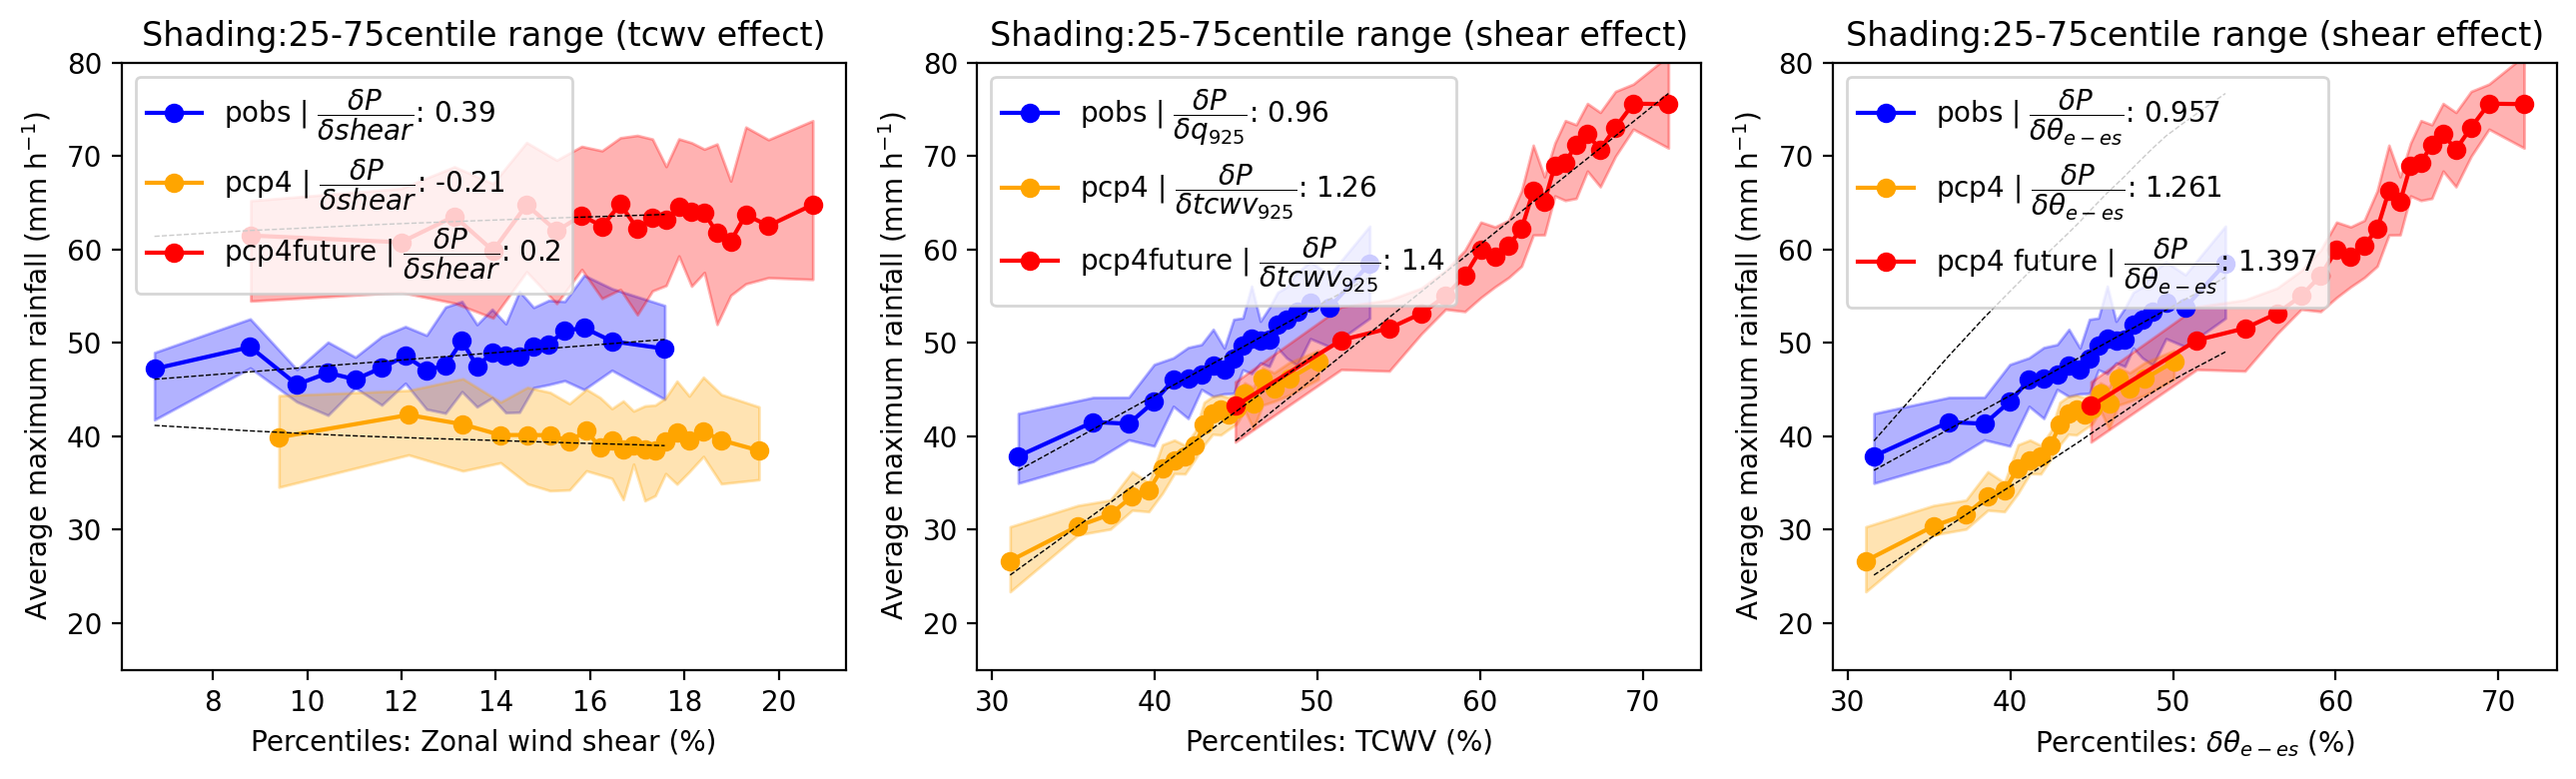

In [127]:
f = plt.figure(figsize=(13,4), dpi=200)

pobs = obs_tcwv_shear
pcp4 = cp4_tcwv_shear
pcp4f = cp4f_tcwv_shear
ax = f.add_subplot(131)
plt.plot(pobs['rbins'],pobs['pmean'],  '-bo', label=r'pobs | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(pobs['rslope'],2)))
plt.fill_between(pobs['rbins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
plt.fill_between(pcp4['rbins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
plt.fill_between(pcp4f['rbins'],pcp4f['p10'],pcp4f['p90'], color='red', alpha=0.3)
plt.plot(pcp4['rbins'],pcp4['pmean'], color='orange', marker='o', label='pcp4 | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(pcp4['rslope'],2)))
plt.plot(pcp4f['rbins'],pcp4f['pmean'], '-ro', label='pcp4future | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(pcp4f['rslope'],2)))
plt.plot(pobs['rbins'],pobs['rslope']*pobs['rbins']+pobs['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pobs['rbins'],pcp4['rslope']*pcp4['rbins']+pcp4['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pobs['rbins'],pcp4f['rslope']*pcp4f['rbins']+pcp4f['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('Percentiles: Zonal wind shear (%)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (tcwv effect)')
#plt.ylim(10,50)
plt.ylim(15,80)
plt.legend(loc='upper left')

         
# pobs = obs_shear_theta
# pcp4 = cp4_shear_theta
# pcp4f = cp4f_shear_theta
pobs = obs_shear_tcwv
pcp4 = cp4_shear_tcwv
pcp4f = cp4f_shear_tcwv
ax = f.add_subplot(133)
plt.plot(pobs['rbins'],pobs['pmean'], '-bo', label=r'pobs | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(pobs['rslope'],3)))
plt.fill_between(pobs['rbins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
plt.fill_between(pcp4['rbins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
plt.fill_between(pcp4f['rbins'],pcp4f['p10'],pcp4f['p90'], color='red', alpha=0.3)
plt.plot(pcp4['rbins'],pcp4['pmean'], color='orange', marker='o', label=r'pcp4 | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(pcp4['rslope'],3)))
plt.plot(pcp4f['rbins'],pcp4f['pmean'], '-ro', label=r'pcp4 future | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(pcp4f['rslope'],3)))
plt.plot(pobs['rbins'],pobs['rslope']*pobs['rbins']+pobs['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pobs['rbins'],pcp4['rslope']*pcp4['rbins']+pcp4['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pobs['rbins'],pcp4f['rslope']*pcp4f['rbins']+pcp4f['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel(r'Percentiles: $\delta \theta _{e-es}$ (%)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (shear effect)')
#plt.ylim(10,0)
plt.ylim(15,80)
plt.legend(loc='upper left')

pobs = obs_shear_tcwv
pcp4 = cp4_shear_tcwv
pcp4f = cp4f_shear_tcwv
ax = f.add_subplot(132)
plt.plot(pobs['rbins'],pobs['pmean'], '-bo', label=r'pobs | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(pobs['rslope'],2)))
plt.fill_between(pobs['rbins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
plt.fill_between(pcp4['rbins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
plt.fill_between(pcp4f['rbins'],pcp4f['p10'],pcp4f['p90'], color='red', alpha=0.3)
plt.plot(pcp4['rbins'],pcp4['pmean'], color='orange', marker='o', label=r'pcp4 | $\dfrac{\delta P}{\delta tcwv_{925}}$: ' + str(np.round(pcp4['rslope'],2)))
plt.plot(pcp4f['rbins'],pcp4f['pmean'], '-ro', label=r'pcp4future | $\dfrac{\delta P}{\delta tcwv_{925}}$: ' + str(np.round(pcp4f['rslope'],2)))
plt.plot(pobs['rbins'],pobs['rslope']*pobs['rbins']+pobs['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pcp4['rbins'],pcp4['rslope']*pcp4['rbins']+pcp4['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pcp4f['rbins'],pcp4f['rslope']*pcp4f['rbins']+pcp4f['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('Percentiles: TCWV (%)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (shear effect)')
#plt.ylim(10,80)
plt.ylim(15,80)
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig(cnst.network_data + 'figs/ENDGAME/scatterOrig_'+tag+'_OBS_CP4futureavg_'+ttag+'_perc.png')

Percentage mean 3.113


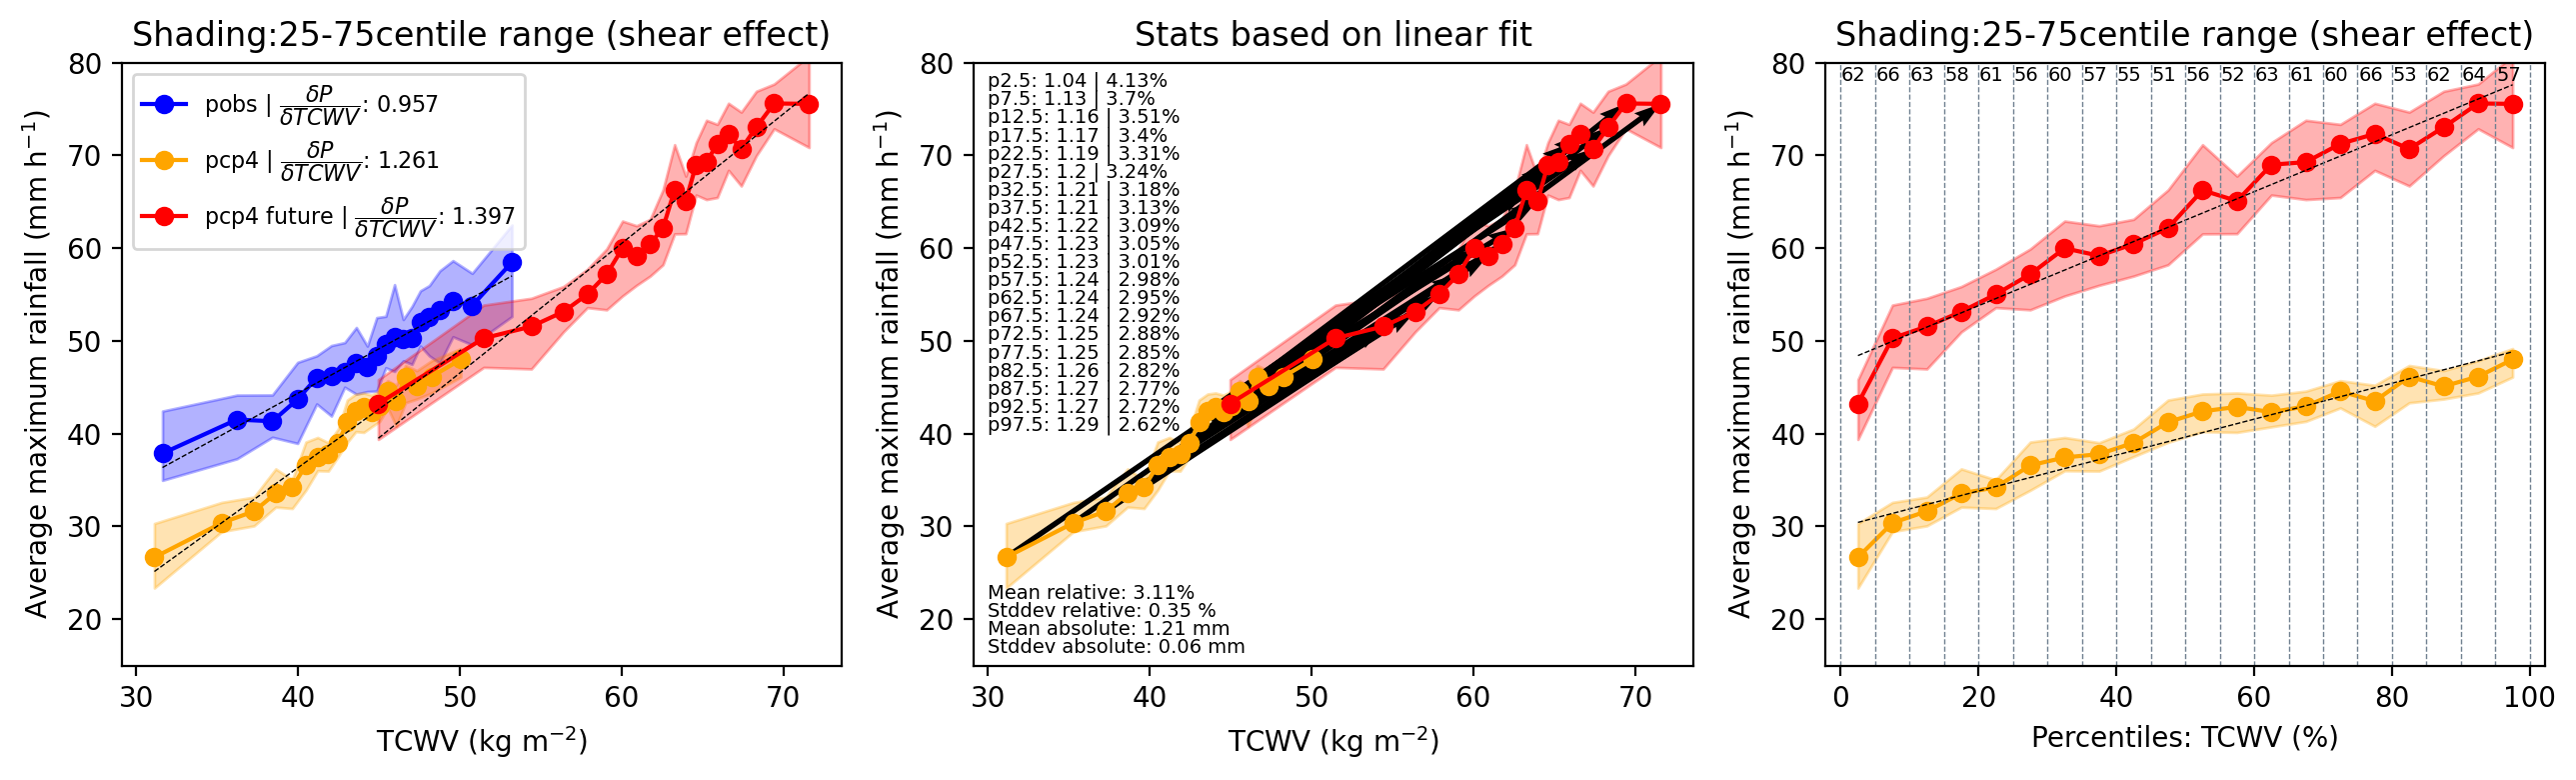

In [128]:
percmid = np.arange(0,101,5)
percents = percmid[0:-1] + (percmid[1::]-percmid[0:-1])/2

f = plt.figure(figsize=(13,4), dpi=200)

         
pobs = obs_shear_tcwv
pcp4 = cp4_shear_tcwv
pcp4f = cp4f_shear_tcwv
ax = f.add_subplot(131)
plt.plot(pobs['rbins'],pobs['pmean'], '-bo', label=r'pobs | $\dfrac{\delta P}{\delta TCWV}$: ' + str(np.round(pobs['rslope'],3)))
plt.fill_between(pobs['rbins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
plt.fill_between(pcp4['rbins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
plt.fill_between(pcp4f['rbins'],pcp4f['p10'],pcp4f['p90'], color='red', alpha=0.3)
plt.plot(pcp4['rbins'],pcp4['pmean'], color='orange', marker='o', label=r'pcp4 | $\dfrac{\delta P}{\delta TCWV}$: ' + str(np.round(pcp4['rslope'],3)))
plt.plot(pcp4f['rbins'],pcp4f['pmean'], '-ro', label=r'pcp4 future | $\dfrac{\delta P}{\delta TCWV}$: ' + str(np.round(pcp4f['rslope'],3)))
plt.plot(pobs['rbins'],pobs['rslope']*pobs['rbins']+pobs['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pcp4['rbins'],pcp4['rslope']*pcp4['rbins']+pcp4['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pcp4f['rbins'],pcp4f['rslope']*pcp4f['rbins']+pcp4f['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel(r'TCWV (kg m$^{-2}$)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (shear effect)')
#plt.ylim(10,0)
plt.ylim(15,80)
plt.legend(loc='upper left', fontsize=8)

pobs = obs_shear_tcwv
pcp4 = cp4_shear_tcwv
pcp4f = cp4f_shear_tcwv
ax = f.add_subplot(132)
#plt.plot(pobs['rbins'],pobs['pmean'], '-bo', label=r'pobs | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(pobs['rslope'],3)))
#plt.fill_between(pobs['rbins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
plt.fill_between(pcp4['rbins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
plt.fill_between(pcp4f['rbins'],pcp4f['p10'],pcp4f['p90'], color='red', alpha=0.3)
plt.plot(pcp4['rbins'],pcp4['pmean'], color='orange', marker='o', label=r'pcp4 | $\dfrac{\delta P}{\delta TCWV}$: ' + str(np.round(pcp4['rslope'],3)))
plt.plot(pcp4f['rbins'],pcp4f['pmean'], '-ro', label=r'pcp4 future | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(pcp4f['rslope'],3)))
#plt.plot(pobs['rbins'],pobs['rslope']*pobs['rbins']+pobs['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
#plt.plot(pcp4['rbins'],pcp4['rslope']*pcp4['rbins']+pcp4['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
#plt.plot(pcp4f['rbins'],pcp4f['rslope']*pcp4f['rbins']+pcp4f['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
#ipdb.set_trace()
plt.quiver(pcp4['rbins'], pcp4['pmean'],(pcp4f['rbins']-pcp4['rbins']),np.array((pcp4f['pmean'])-np.array(pcp4['pmean'])), angles='xy', scale_units='xy', scale=1)

coll = []
abss = []

for ids, percs in enumerate(percents):
    #ppabs = (np.array((pcp4f['pmean'][ids])-np.array(pcp4['pmean'][ids]))/((pcp4f['rbins'][ids]-pcp4['rbins'][ids])))
    
    ppabs = (np.array(((pcp4f['rslope']*pcp4f['rbins']+pcp4f['rintercept'])[ids])-np.array((pcp4['rslope']*pcp4['rbins']+pcp4['rintercept'])[ids]))/((pcp4f['rbins'][ids]-pcp4['rbins'][ids])))
    
    pperc = np.round(ppabs / (pcp4['rslope']*pcp4['rbins']+pcp4['rintercept'])[ids]*100,2)
    plt.text(0.02, 0.96-ids*0.03,'p'+str(percs)+': ' + str(np.round(ppabs,2)) + ' | ' + str(pperc)+'%', transform=ax.transAxes, fontsize=7)  #(0.02, 0.08, 'ITD 0-line', color='turquoise', fontsize=12, transform=ax.transAxes)
    coll.append(pperc)
    abss.append(ppabs)

print('Percentage mean', np.mean(coll))

plt.text(0.02, 0.11,'Mean relative: '+str(np.round(np.mean(coll),2))+'%', transform=ax.transAxes, fontsize=7)
plt.text(0.02, 0.08,'Stddev relative: '+str(np.round(np.std(coll),2))+' %', transform=ax.transAxes, fontsize=7)
plt.text(0.02, 0.05,'Mean absolute: '+str(np.round(np.mean(abss),2))+' mm', transform=ax.transAxes, fontsize=7)
plt.text(0.02, 0.02,'Stddev absolute: '+str(np.round(np.std(abss),2))+' mm', transform=ax.transAxes, fontsize=7)

    
plt.xlabel(r'TCWV (kg m$^{-2}$)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Stats based on linear fit')
#plt.ylim(10,0)
plt.ylim(15,80)

pobs = obs_shear_tcwv
pcp4 = cp4_shear_tcwv
pcp4f = cp4f_shear_tcwv
ax = f.add_subplot(133)
#plt.plot(pobs['bins'],pobs['pmean'], '-bo', label=r'pobs | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(pobs['slope'],2)))
#plt.fill_between(pobs['bins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
plt.fill_between(pcp4['bins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
plt.fill_between(pcp4f['bins'],pcp4f['p10'],pcp4f['p90'], color='red', alpha=0.3)
plt.plot(pcp4['bins'],pcp4['pmean'], color='orange', marker='o', label=r'pcp4 | $\dfrac{\delta P}{\delta tcwv_{925}}$: ' + str(np.round(pcp4['slope'],2)))
plt.plot(pcp4f['bins'],pcp4f['pmean'], '-ro', label=r'pcp4future | $\dfrac{\delta P}{\delta tcwv_{925}}$: ' + str(np.round(pcp4f['slope'],2)))
#plt.plot(pobs['bins'],pobs['slope']*pobs['bins']+pobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pcp4['bins'],pcp4['slope']*pcp4['bins']+pcp4['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pcp4f['bins'],pcp4f['slope']*pcp4f['bins']+pcp4f['intercept'], linestyle='dashed', color='k', linewidth=0.5)
allrel = []
allabs = []
for ids, pp in enumerate(np.arange(0,101,5)):
    plt.axvline(pp, color='slategrey', linestyle='dashed', linewidth=0.5)
    try:
        ttext = np.round((np.array(pcp4f['pmean'])[ids]-np.array(pcp4['pmean'])[ids])/(np.array(pcp4['pmean'])[ids])*100,0).astype(int)
        plt.text(pp+0.1, 78,str(ttext), fontsize=7)
        allrel.append(ttext)
        allabs.append((np.array(pcp4f['pmean'])[ids]-np.array(pcp4['pmean'])[ids]))
    except:
        pass

plt.xlabel('Percentiles: TCWV (%)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (shear effect)')
#plt.ylim(10,80)
plt.ylim(15,80)
#plt.legend(loc='upper left')
plt.ylim(15,80)


plt.tight_layout()
#plt.savefig(cnst.network_data + 'figs/ENDGAME/scatter_'+tag+'_OBS_CP4futureavg_linfit_'+ttag+'.png')

In [129]:
print(np.mean(allrel))
print(np.std(allrel))

59.15
4.327528162819972


In [130]:
print(np.mean(allabs))
print(np.std(allabs))

23.388214070539764
3.545394195667466


In [131]:
tdiff = pcp4f['rbins']-pcp4['rbins']

In [132]:
np.std(np.array(allrel)[0::]/np.array(tdiff)[0::])

0.4724921775710732

Text(0, 0.5, 'mm')

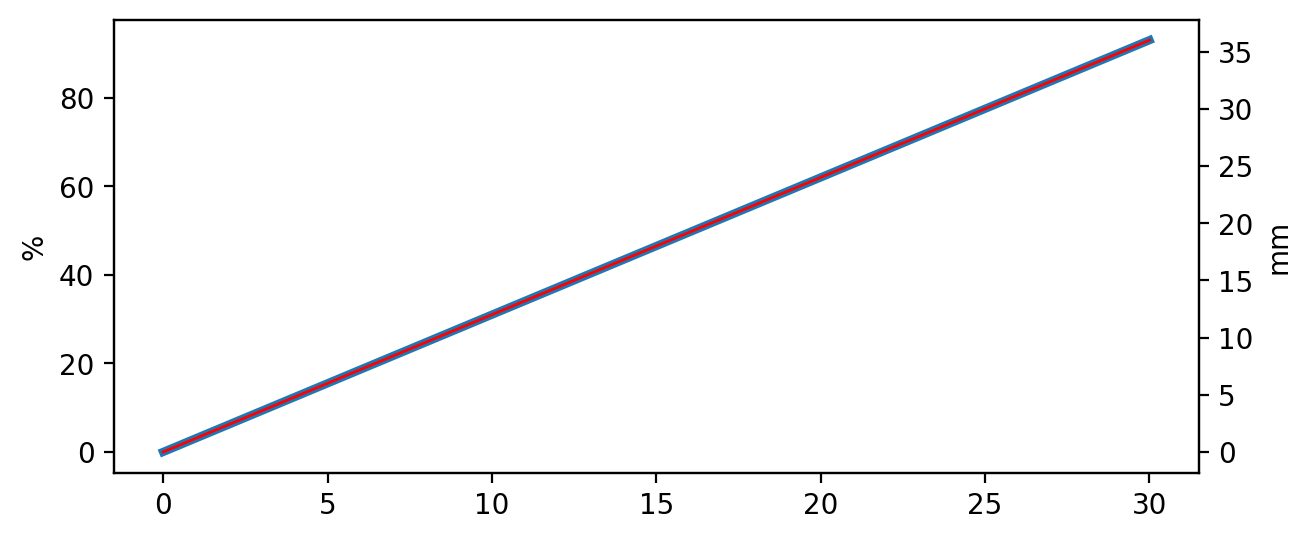

In [133]:
f = plt.figure(figsize=(7,3), dpi=200)
ax = f.add_subplot(111)
ax.plot(np.arange(0,31), np.arange(0,31)*3.1, linewidth=3)
ax.set_ylabel('%')
ax1 = ax.twinx()
ax1.plot(np.arange(0,31), np.arange(0,31)*1.2, color='red', linewidth=1)
ax1.set_ylabel('mm')

In [134]:
yposis = []
yposisf = []
xposis = []
xposisf = []
for rb, rbf in zip(pcp4['rbins'],pcp4f['rbins']):
    yposi = np.nanargmin(np.abs(rb-cp4_basic['xbins']))
    yfposi = np.nanargmin(np.abs(rbf-cp4f_basic['xbins']))
    
    xposi = (cp4_basic['nb']/np.sum(cp4_basic['nb']))[yposi]
    xfposi = (cp4f_basic['nb']/np.sum(cp4f_basic['nb']))[yfposi]
    
#     ipdb.set_trace()

#     pos = np.where(yposis == xposi)
#     if np.sum(np.isfinite(pos)) != 0:
#             xposi = (cp4_basic['nb']/np.sum(cp4_basic['nb']))[yposi+1]

    xposis.append((cp4_basic['xbins'])[yposi])
    xposisf.append((cp4f_basic['xbins'])[yfposi])
    yposis.append(xposi)
    yposisf.append(xfposi)

In [135]:
yposis = np.array(yposis)
yposisf = np.array(yposisf)
xposis = np.array(xposis)
xposisf=np.array(xposisf)

In [136]:
percmid = np.arange(0,101,5)
percents = percmid[0:-1] + (percmid[1::]-percmid[0:-1])/2

In [137]:
pcp4['rbins']

array([31.12, 35.28, 37.28, 38.62, 39.64, 40.48, 41.21, 41.87, 42.48,
       43.04, 43.57, 44.06, 44.54, 45.04, 45.54, 46.07, 46.64, 47.34,
       48.26, 50.06])

In [138]:
pcp4['pmean']

[26.66509091267525,
 30.376347155394278,
 31.638707320046073,
 33.56216082939217,
 34.20953309569826,
 36.58455626222529,
 37.434160592827936,
 37.79353808875737,
 39.0148220624391,
 41.24124274088869,
 42.40677930017522,
 42.88879413011772,
 42.317813889977614,
 42.946589112033976,
 44.56942666624931,
 43.51088476148204,
 46.14536265115002,
 45.10342888793276,
 46.15647433566893,
 47.99864333421434]

Percentage median 3.021977069661694


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


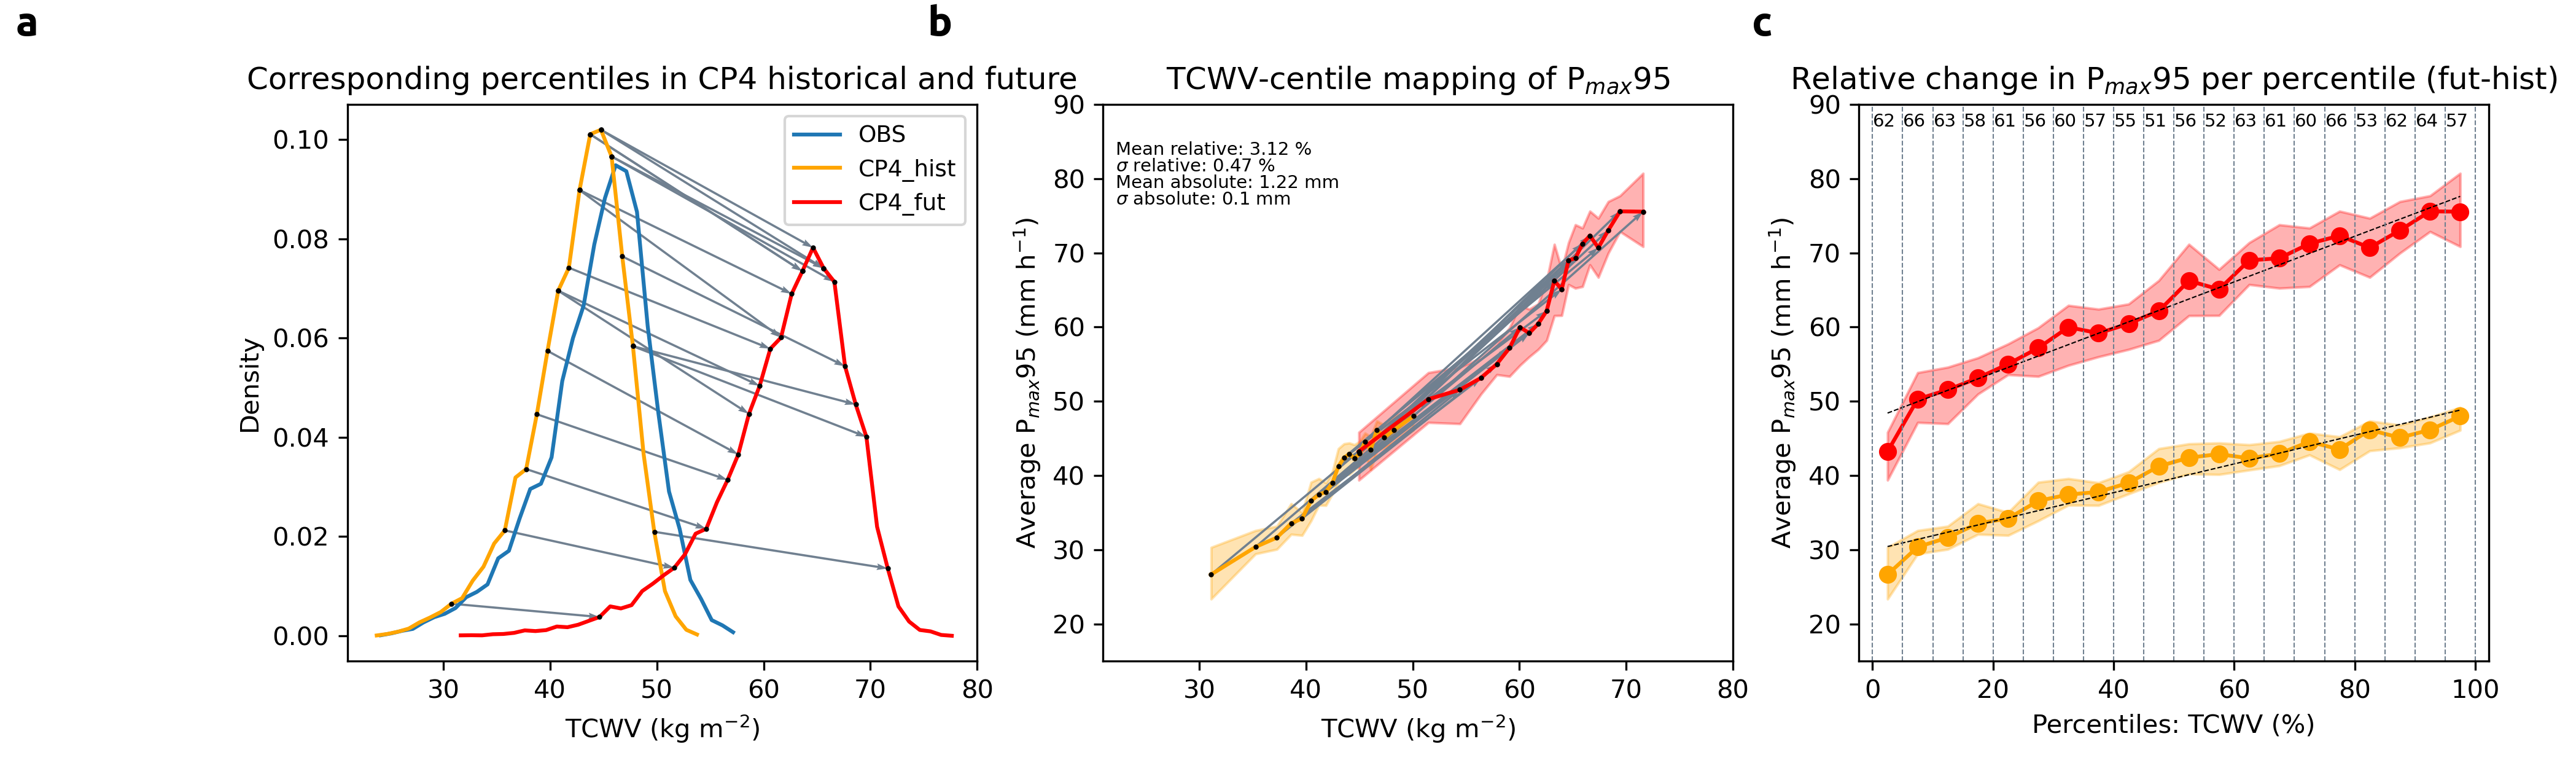

In [139]:


f = plt.figure(figsize=(15,4), dpi=300)

         
ax = f.add_subplot(131)
plt.plot(obs_basic['xbins'], obs_basic['nb']/np.sum(obs_basic['nb']), label='OBS')
plt.plot(cp4_basic['xbins'], cp4_basic['nb']/np.sum(cp4_basic['nb']), color='orange', label='CP4_hist')
plt.plot(cp4f_basic['xbins'], cp4f_basic['nb']/np.sum(cp4f_basic['nb']), color='red', label='CP4_fut')
plt.quiver(xposis, yposis,xposisf-xposis,yposisf-yposis, angles='xy', scale_units='xy', scale=1,  width=0.0035, color='slategrey')
plt.plot(xposis, yposis, marker='o', linestyle='none', markersize=1, color='k')
plt.plot(xposisf, yposisf, marker='o', linestyle='none', markersize=1, color='k')
plt.ylabel('Density')
plt.xlabel('TCWV (kg m$^{-2}$)')
plt.legend(loc='upper right', fontsize=9)
plt.title('Corresponding percentiles in CP4 historical and future')
plt.xlim(21,80)

pobs = obs_shear_tcwv
pcp4 = cp4_shear_tcwv
pcp4f = cp4f_shear_tcwv
ax = f.add_subplot(132)
#plt.plot(pobs['rbins'],pobs['pmean'], '-bo', label=r'pobs | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(pobs['rslope'],3)))
#plt.fill_between(pobs['rbins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
plt.fill_between(pcp4['rbins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
plt.fill_between(pcp4f['rbins'],pcp4f['p10'],pcp4f['p90'], color='red', alpha=0.3)
plt.plot(pcp4['rbins'],pcp4['pmean'], color='orange', marker='o', markersize=1, label=r'pcp4 | $\dfrac{\delta P}{\delta TCWV}$: ' + str(np.round(pcp4['rslope'],3)))
plt.plot(pcp4f['rbins'],pcp4f['pmean'], color='red', marker='o', markersize=1, label=r'pcp4 future | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(pcp4f['rslope'],3)))
plt.plot(pcp4['rbins'],pcp4['pmean'], color='k', marker='o', linestyle='none',markersize=1)
plt.plot(pcp4f['rbins'],pcp4f['pmean'], color='k', marker='o', linestyle='none', markersize=1)
#plt.plot(pobs['rbins'],pobs['rslope']*pobs['rbins']+pobs['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
#plt.plot(pcp4['rbins'],pcp4['rslope']*pcp4['rbins']+pcp4['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
#plt.plot(pcp4f['rbins'],pcp4f['rslope']*pcp4f['rbins']+pcp4f['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
#ipdb.set_trace()
plt.quiver(pcp4['rbins'], pcp4['pmean'],(pcp4f['rbins']-pcp4['rbins']),np.array((pcp4f['pmean'])-np.array(pcp4['pmean'])), angles='xy', scale_units='xy', scale=1, color='slategrey', width=0.0035)
plt.xlim(21,80)
coll = []
abss = []

for ids, percs in enumerate(percents):
    ppabs = (np.array((pcp4f['pmean'][ids])-np.array(pcp4['pmean'][ids]))/((pcp4f['rbins'][ids]-pcp4['rbins'][ids])))
    pperc = (ppabs / pcp4['pmean'][ids])*100
    #plt.text(0.02, 0.96-ids*0.03,'p'+str(percs)+': ' + str(np.round(ppabs,2)) + ' | ' + str(np.round(pperc,2))+'%', transform=ax.transAxes, fontsize=7)  #(0.02, 0.08, 'ITD 0-line', color='turquoise', fontsize=12, transform=ax.transAxes)
    coll.append(pperc)
    abss.append(ppabs)

print('Percentage median', np.median(coll))

# plt.text(0.02, 0.11,'Mean relative: '+str(np.round(np.mean(coll),2))+'%', transform=ax.transAxes, fontsize=7)
# plt.text(0.02, 0.08,'Stddev relative: '+str(np.round(np.std(coll),2))+' %', transform=ax.transAxes, fontsize=7)
# plt.text(0.02, 0.05,'Mean absolute: '+str(np.round(np.mean(abss),2))+' mm', transform=ax.transAxes, fontsize=7)
# plt.text(0.02, 0.02,'Stddev absolute: '+str(np.round(np.std(abss),2))+' mm', transform=ax.transAxes, fontsize=7)

plt.text(0.02, 0.91,'Mean relative: '+str(np.round(np.mean(coll),2))+' %', transform=ax.transAxes, fontsize=7)
plt.text(0.02, 0.88,r'$\sigma$ relative: '+str(np.round(np.std(coll),2))+' %', transform=ax.transAxes, fontsize=7)
plt.text(0.02, 0.85,'Mean absolute: '+str(np.round(np.mean(abss),2))+' mm', transform=ax.transAxes, fontsize=7)
plt.text(0.02, 0.82,'$\sigma$ absolute: '+str(np.round(np.std(abss),2))+' mm', transform=ax.transAxes, fontsize=7)
    
plt.xlabel(r'TCWV (kg m$^{-2}$)')
plt.ylabel('Average P$_{max}$95 (mm h$^{-1}$)')
plt.title('TCWV-centile mapping of P$_{max}$95')
#plt.ylim(10,0)
plt.ylim(15,90)

pobs = obs_shear_tcwv
pcp4 = cp4_shear_tcwv
pcp4f = cp4f_shear_tcwv
ax = f.add_subplot(133)
#plt.plot(pobs['bins'],pobs['pmean'], '-bo', label=r'pobs | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(pobs['slope'],2)))
#plt.fill_between(pobs['bins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
plt.fill_between(pcp4['bins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
plt.fill_between(pcp4f['bins'],pcp4f['p10'],pcp4f['p90'], color='red', alpha=0.3)
plt.plot(pcp4['bins'],pcp4['pmean'], color='orange', marker='o', label=r'pcp4 | $\dfrac{\delta P}{\delta tcwv_{925}}$: ' + str(np.round(pcp4['slope'],2)))
plt.plot(pcp4f['bins'],pcp4f['pmean'], '-ro', label=r'pcp4future | $\dfrac{\delta P}{\delta tcwv_{925}}$: ' + str(np.round(pcp4f['slope'],2)))
#plt.plot(pobs['bins'],pobs['slope']*pobs['bins']+pobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pcp4['bins'],pcp4['slope']*pcp4['bins']+pcp4['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pcp4f['bins'],pcp4f['slope']*pcp4f['bins']+pcp4f['intercept'], linestyle='dashed', color='k', linewidth=0.5)
for ids, pp in enumerate(np.arange(0,101,5)):
    plt.axvline(pp, color='slategrey', linestyle='dashed', linewidth=0.5)
    try:
        ttext = np.round((np.array(pcp4f['pmean'])[ids]-np.array(pcp4['pmean'])[ids])/(np.array(pcp4['pmean'])[ids])*100,0).astype(int)
        plt.text(pp+0.1, 87,str(ttext), fontsize=7)
    except:
        pass

plt.xlabel('Percentiles: TCWV (%)')
plt.ylabel('Average P$_{max}$95 (mm h$^{-1}$)')
plt.title('Relative change in P$_{max}$95 per percentile (fut-hist)')
#plt.ylim(10,80)
plt.ylim(15,90)
#plt.legend(loc='upper left')
plt.ylim(15,90)

text = ['a', 'b', 'c']
plt.annotate(text[0], xy=(0.006, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.36, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.68, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)

plt.tight_layout()
#plt.savefig(cnst.network_data + 'figs/ENDGAME/scatter_'+tag+'_OBS_CP4futureavg_'+ttag+'_TCWV2_d.png')

In [140]:
30*0.74

22.2

No handles with labels found to put in legend.


Percentage median 3.021977069661694


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


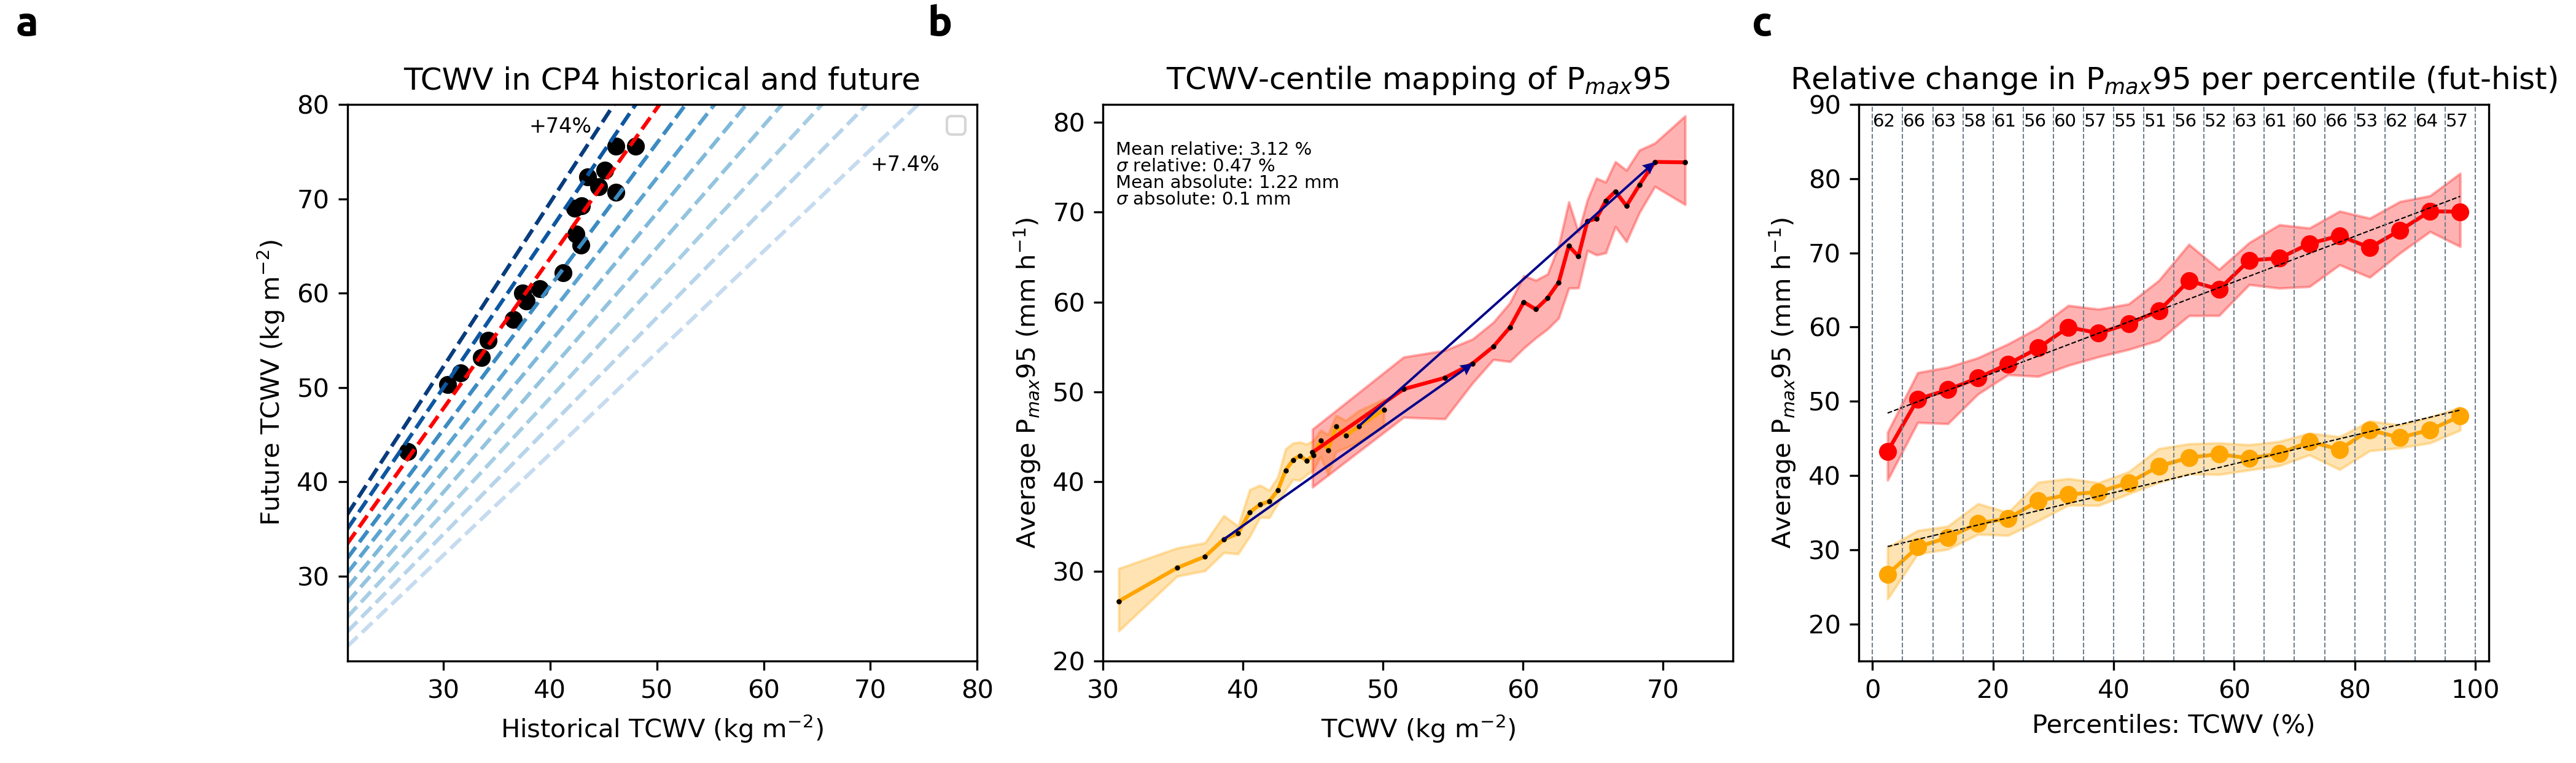

In [141]:
f = plt.figure(figsize=(15,4), dpi=300)

         
ax = f.add_subplot(131)
plt.scatter(pcp4['pmean'],pcp4f['pmean'], color='k')
cmap=plt.get_cmap("Blues")
plt.plot(np.arange(21,80), np.arange(21,80)+0.074*np.arange(21,80), color=cmap(0.25), linestyle='dashed')
plt.plot(np.arange(21,80), np.arange(21,80)+2*0.074*np.arange(21,80), color=cmap(0.3), linestyle='dashed')
plt.plot(np.arange(21,80), np.arange(21,80)+3*0.074*np.arange(21,80), color=cmap(0.35), linestyle='dashed')
plt.plot(np.arange(21,80), np.arange(21,80)+4*0.074*np.arange(21,80), color=cmap(0.4), linestyle='dashed')
plt.plot(np.arange(21,80), np.arange(21,80)+5*0.074*np.arange(21,80), color=cmap(0.45), linestyle='dashed')
plt.plot(np.arange(21,80), np.arange(21,80)+6*0.074*np.arange(21,80), color=cmap(0.55), linestyle='dashed')
plt.plot(np.arange(21,80), np.arange(21,80)+7*0.074*np.arange(21,80), color=cmap(0.65), linestyle='dashed')
plt.plot(np.arange(21,80), np.arange(21,80)+8*0.074*np.arange(21,80), color='red', linestyle='dashed')
plt.plot(np.arange(21,80), np.arange(21,80)+9*0.074*np.arange(21,80), color=cmap(0.85), linestyle='dashed')
plt.plot(np.arange(21,80), np.arange(21,80)+10*0.074*np.arange(21,80), color=cmap(0.95), linestyle='dashed')
plt.text(70,73,'+7.4%', fontsize=8)
plt.text(38,77,'+74%', fontsize=8)
plt.ylabel('Future TCWV (kg m$^{-2}$)')
plt.xlabel('Historical TCWV (kg m$^{-2}$)')
plt.legend(loc='upper right', fontsize=9)
plt.title('TCWV in CP4 historical and future')
plt.xlim(21,80)
plt.ylim(21,80)

pobs = obs_shear_tcwv
pcp4 = cp4_shear_tcwv
pcp4f = cp4f_shear_tcwv
ax = f.add_subplot(132)
#plt.plot(pobs['rbins'],pobs['pmean'], '-bo', label=r'pobs | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(pobs['rslope'],3)))
#plt.fill_between(pobs['rbins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
plt.fill_between(pcp4['rbins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
plt.fill_between(pcp4f['rbins'],pcp4f['p10'],pcp4f['p90'], color='red', alpha=0.3)
plt.plot(pcp4['rbins'],pcp4['pmean'], color='orange', marker='o', markersize=1, label=r'pcp4 | $\dfrac{\delta P}{\delta TCWV}$: ' + str(np.round(pcp4['rslope'],3)))
plt.plot(pcp4f['rbins'],pcp4f['pmean'], color='red', marker='o', markersize=1, label=r'pcp4 future | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(pcp4f['rslope'],3)))
plt.plot(pcp4['rbins'],pcp4['pmean'], color='k', marker='o', linestyle='none',markersize=1)
plt.plot(pcp4f['rbins'],pcp4f['pmean'], color='k', marker='o', linestyle='none', markersize=1)
#plt.plot(pobs['rbins'],pobs['rslope']*pobs['rbins']+pobs['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
#plt.plot(pcp4['rbins'],pcp4['rslope']*pcp4['rbins']+pcp4['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
#plt.plot(pcp4f['rbins'],pcp4f['rslope']*pcp4f['rbins']+pcp4f['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
#ipdb.set_trace()
plt.quiver(pcp4['rbins'][3::15], pcp4['pmean'][3::15],(pcp4f['rbins']-pcp4['rbins'])[3::15],np.array((pcp4f['pmean'])-np.array(pcp4['pmean']))[3::15], angles='xy', scale_units='xy', scale=1, color='darkblue', width=0.0038, zorder=99, headwidth=5)
plt.xlim(30,75)
coll = []
abss = []

for ids, percs in enumerate(percents):
    ppabs = (np.array((pcp4f['pmean'][ids])-np.array(pcp4['pmean'][ids]))/((pcp4f['rbins'][ids]-pcp4['rbins'][ids])))
    pperc = (ppabs / pcp4['pmean'][ids])*100
    #plt.text(0.02, 0.96-ids*0.03,'p'+str(percs)+': ' + str(np.round(ppabs,2)) + ' | ' + str(np.round(pperc,2))+'%', transform=ax.transAxes, fontsize=7)  #(0.02, 0.08, 'ITD 0-line', color='turquoise', fontsize=12, transform=ax.transAxes)
    coll.append(pperc)
    abss.append(ppabs)

print('Percentage median', np.median(coll))

# plt.text(0.02, 0.11,'Mean relative: '+str(np.round(np.mean(coll),2))+'%', transform=ax.transAxes, fontsize=7)
# plt.text(0.02, 0.08,'Stddev relative: '+str(np.round(np.std(coll),2))+' %', transform=ax.transAxes, fontsize=7)
# plt.text(0.02, 0.05,'Mean absolute: '+str(np.round(np.mean(abss),2))+' mm', transform=ax.transAxes, fontsize=7)
# plt.text(0.02, 0.02,'Stddev absolute: '+str(np.round(np.std(abss),2))+' mm', transform=ax.transAxes, fontsize=7)

plt.text(0.02, 0.91,'Mean relative: '+str(np.round(np.mean(coll),2))+' %', transform=ax.transAxes, fontsize=7)
plt.text(0.02, 0.88,r'$\sigma$ relative: '+str(np.round(np.std(coll),2))+' %', transform=ax.transAxes, fontsize=7)
plt.text(0.02, 0.85,'Mean absolute: '+str(np.round(np.mean(abss),2))+' mm', transform=ax.transAxes, fontsize=7)
plt.text(0.02, 0.82,'$\sigma$ absolute: '+str(np.round(np.std(abss),2))+' mm', transform=ax.transAxes, fontsize=7)
    
plt.xlabel(r'TCWV (kg m$^{-2}$)')
plt.ylabel('Average P$_{max}$95 (mm h$^{-1}$)')
plt.title('TCWV-centile mapping of P$_{max}$95')
#plt.ylim(10,0)
plt.ylim(20,82)

pobs = obs_shear_tcwv
pcp4 = cp4_shear_tcwv
pcp4f = cp4f_shear_tcwv
ax = f.add_subplot(133)
#plt.plot(pobs['bins'],pobs['pmean'], '-bo', label=r'pobs | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(pobs['slope'],2)))
#plt.fill_between(pobs['bins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
plt.fill_between(pcp4['bins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
plt.fill_between(pcp4f['bins'],pcp4f['p10'],pcp4f['p90'], color='red', alpha=0.3)
plt.plot(pcp4['bins'],pcp4['pmean'], color='orange', marker='o', label=r'pcp4 | $\dfrac{\delta P}{\delta tcwv_{925}}$: ' + str(np.round(pcp4['slope'],2)))
plt.plot(pcp4f['bins'],pcp4f['pmean'], '-ro', label=r'pcp4future | $\dfrac{\delta P}{\delta tcwv_{925}}$: ' + str(np.round(pcp4f['slope'],2)))
#plt.plot(pobs['bins'],pobs['slope']*pobs['bins']+pobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pcp4['bins'],pcp4['slope']*pcp4['bins']+pcp4['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pcp4f['bins'],pcp4f['slope']*pcp4f['bins']+pcp4f['intercept'], linestyle='dashed', color='k', linewidth=0.5)
for ids, pp in enumerate(np.arange(0,101,5)):
    plt.axvline(pp, color='slategrey', linestyle='dashed', linewidth=0.5)
    try:
        ttext = np.round((np.array(pcp4f['pmean'])[ids]-np.array(pcp4['pmean'])[ids])/(np.array(pcp4['pmean'])[ids])*100,0).astype(int)
        plt.text(pp+0.1, 87,str(ttext), fontsize=7)
    except:
        pass

plt.xlabel('Percentiles: TCWV (%)')
plt.ylabel('Average P$_{max}$95 (mm h$^{-1}$)')
plt.title('Relative change in P$_{max}$95 per percentile (fut-hist)')
#plt.ylim(10,80)
plt.ylim(15,90)
#plt.legend(loc='upper left')
plt.ylim(15,90)

text = ['a', 'b', 'c']
plt.annotate(text[0], xy=(0.006, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.36, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.68, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)

plt.tight_layout()
#plt.savefig(cnst.network_data + 'figs/ENDGAME/scatter_'+tag+'_OBS_CP4futureavg_'+ttag+'_TCWV2_d.png')

In [142]:
pcp4.keys()

dict_keys(['slope', 'intercept', 'rval', 'pval', 'std_err', 'prcp_span', 'prcp_IQR', 'pbox', 'tbox', 'pmean', 'p90', 'p10', 'tmean', 't90', 't10', 'bins', 'rbins', 'rslope', 'rintercept', 'rrval', 'rpval', 'rstd_err'])

Percentage median 3.021977069661694


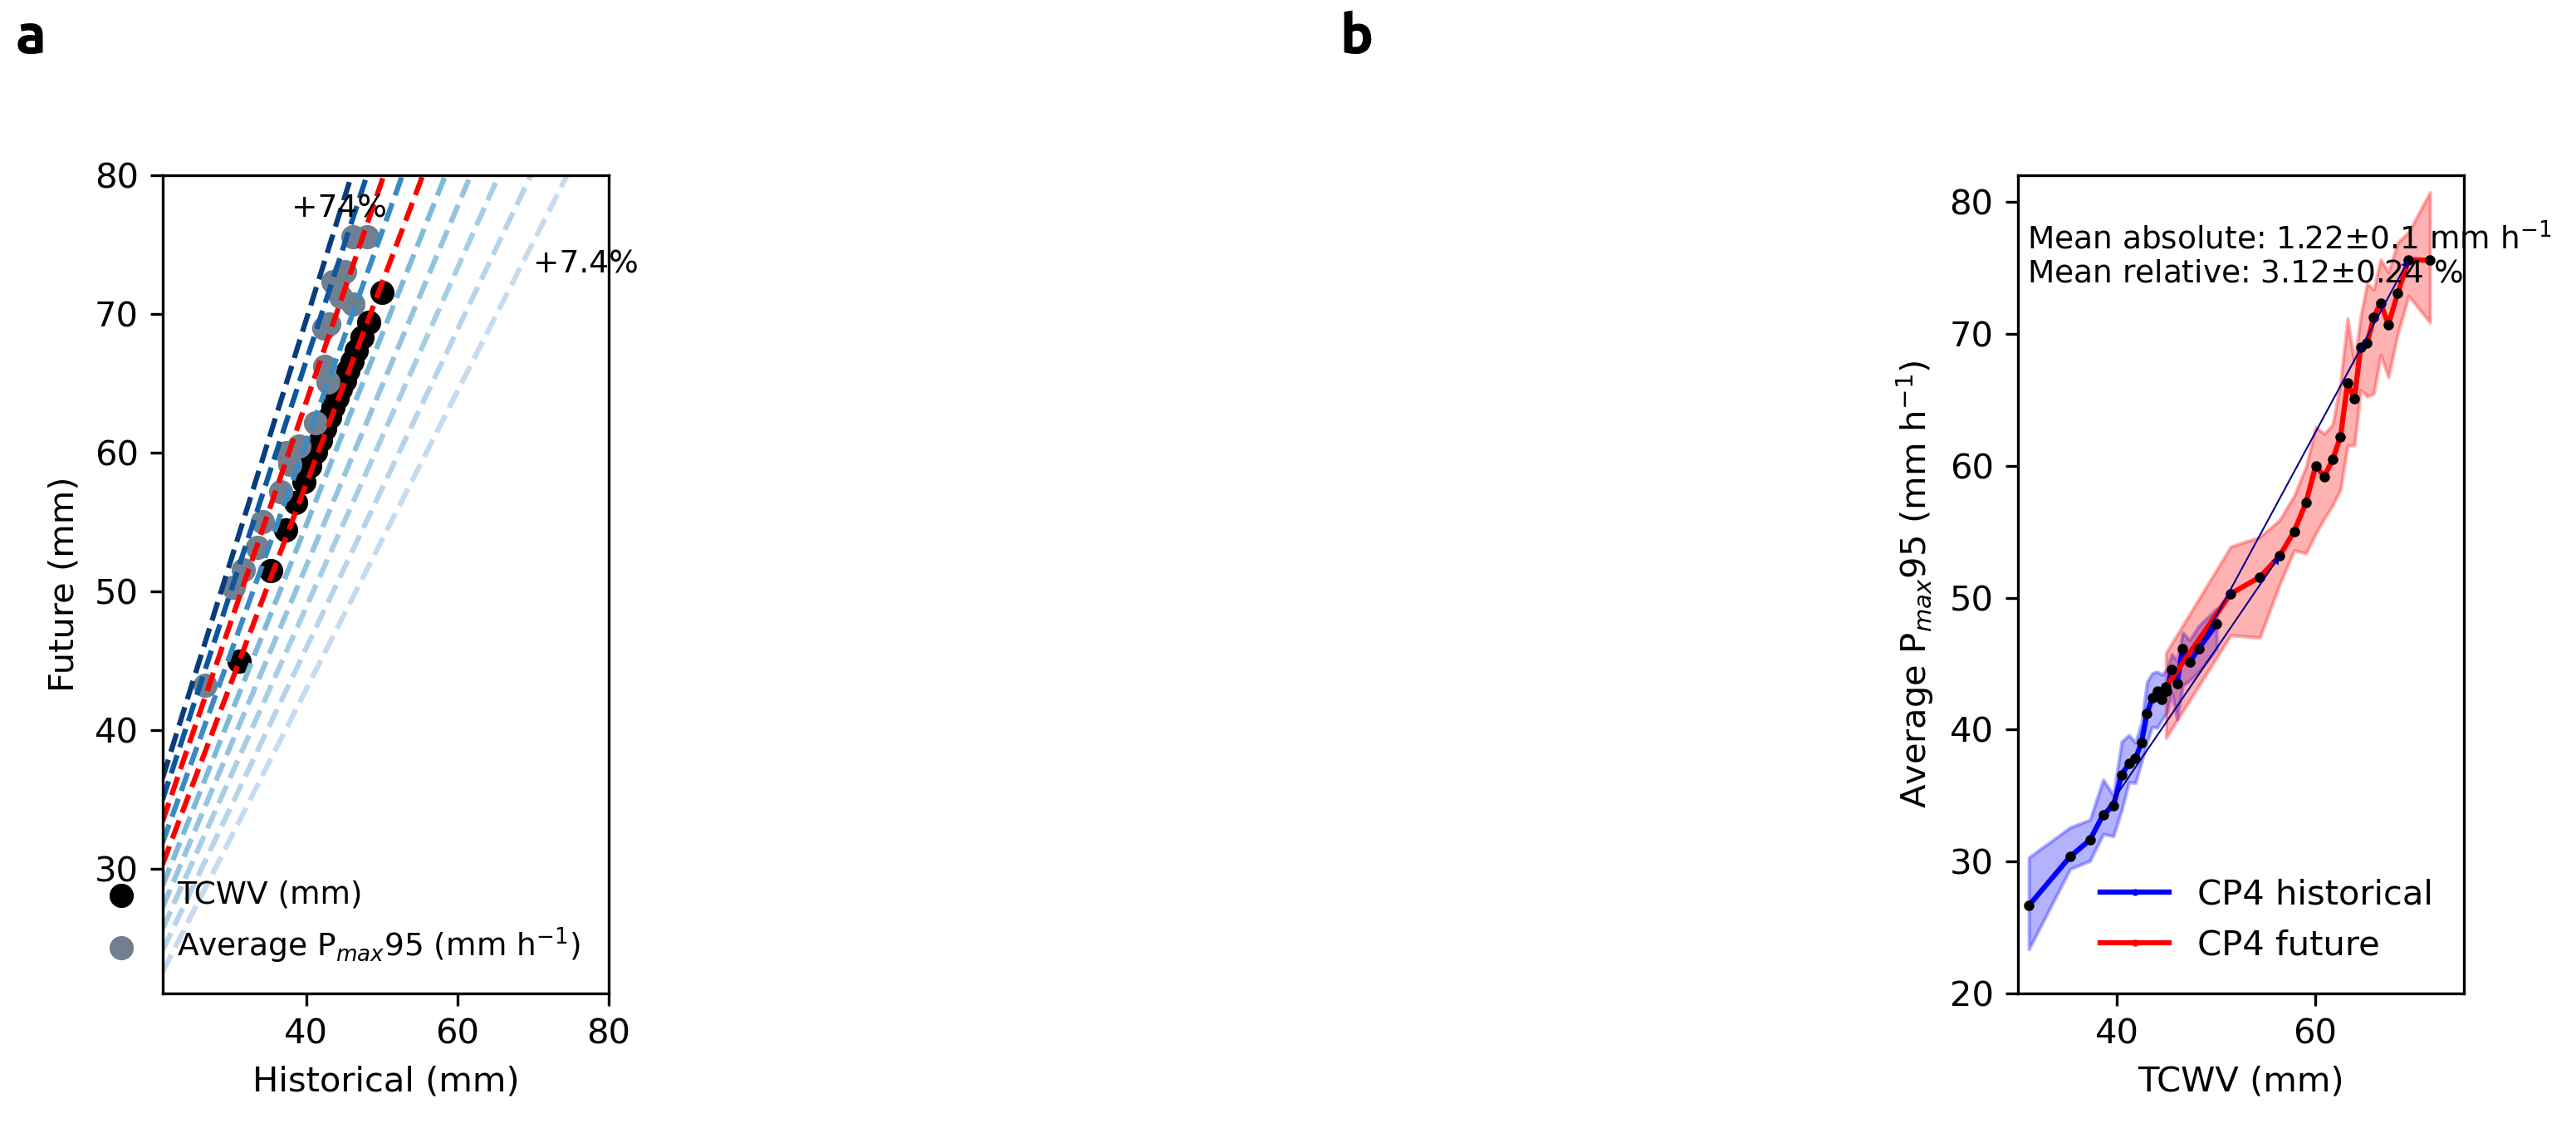

In [143]:
f = plt.figure(figsize=(10,4.5), dpi=300)
     
ax = f.add_subplot(121)
plt.scatter(pcp4['rbins'],pcp4f['rbins'], color='k', label='TCWV (mm)') #pmean
plt.scatter(pcp4['pmean'],pcp4f['pmean'], color='slategrey', label='Average P$_{max}$95 (mm h$^{-1}$)')
cmap=plt.get_cmap("Blues")
plt.plot(np.arange(21,80), np.arange(21,80)+0.074*np.arange(21,80), color=cmap(0.25), linestyle='dashed')
plt.plot(np.arange(21,80), np.arange(21,80)+2*0.074*np.arange(21,80), color=cmap(0.3), linestyle='dashed')
plt.plot(np.arange(21,80), np.arange(21,80)+3*0.074*np.arange(21,80), color=cmap(0.35), linestyle='dashed')
plt.plot(np.arange(21,80), np.arange(21,80)+4*0.074*np.arange(21,80), color=cmap(0.4), linestyle='dashed')
plt.plot(np.arange(21,80), np.arange(21,80)+5*0.074*np.arange(21,80), color=cmap(0.45), linestyle='dashed')
plt.plot(np.arange(21,80), np.arange(21,80)+6*0.074*np.arange(21,80), color='red', linestyle='dashed') #cmap(0.55)
plt.plot(np.arange(21,80), np.arange(21,80)+7*0.074*np.arange(21,80), color=cmap(0.65), linestyle='dashed')
plt.plot(np.arange(21,80), np.arange(21,80)+8*0.074*np.arange(21,80), color='red', linestyle='dashed')
plt.plot(np.arange(21,80), np.arange(21,80)+9*0.074*np.arange(21,80), color=cmap(0.85), linestyle='dashed')
plt.plot(np.arange(21,80), np.arange(21,80)+10*0.074*np.arange(21,80), color=cmap(0.95), linestyle='dashed')

#plt.plot(np.arange(21,80), np.arange(21,80)+5, color='k', linestyle='dashed')

plt.text(70,73,'+7.4%', fontsize=9)
plt.text(38,77,'+74%', fontsize=9)
plt.ylabel('Future (mm)')
plt.xlabel('Historical (mm)')
plt.legend(loc='lower right', fontsize=9, frameon=False)
#plt.title('TCWV in CP4 historical and future')
plt.xlim(21,80)
plt.ylim(21,80)

pobs = obs_shear_tcwv
pcp4 = cp4_shear_tcwv
pcp4f = cp4f_shear_tcwv
ax = f.add_subplot(122)
#plt.plot(pobs['rbins'],pobs['pmean'], '-bo', label=r'pobs | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(pobs['rslope'],3)))
#plt.fill_between(pobs['rbins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
plt.fill_between(pcp4['rbins'],pcp4['p10'],pcp4['p90'], color='blue', alpha=0.3)
plt.fill_between(pcp4f['rbins'],pcp4f['p10'],pcp4f['p90'], color='red', alpha=0.3)
plt.plot(pcp4['rbins'],pcp4['pmean'], color='blue', marker='o', markersize=1, label=r'CP4 historical')
plt.plot(pcp4f['rbins'],pcp4f['pmean'], color='red', marker='o', markersize=1, label=r'CP4 future')
plt.plot(pcp4['rbins'],pcp4['pmean'], color='k', marker='o', linestyle='none',markersize=2)
plt.plot(pcp4f['rbins'],pcp4f['pmean'], color='k', marker='o', linestyle='none', markersize=2)
#plt.plot(pobs['rbins'],pobs['rslope']*pobs['rbins']+pobs['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
#plt.plot(pcp4['rbins'],pcp4['rslope']*pcp4['rbins']+pcp4['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
#plt.plot(pcp4f['rbins'],pcp4f['rslope']*pcp4f['rbins']+pcp4f['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
#ipdb.set_trace()
plt.quiver(pcp4['rbins'][3::15], pcp4['pmean'][3::15],(pcp4f['rbins']-pcp4['rbins'])[3::15],np.array((pcp4f['pmean'])-np.array(pcp4['pmean']))[3::15], angles='xy', scale_units='xy', scale=1, color='darkblue', width=0.0038, zorder=99, headwidth=5)
plt.xlim(30,75)
plt.legend(loc='lower right', frameon=False)
coll = []
abss = []

for ids, percs in enumerate(percents):
    ppabs = (np.array((pcp4f['pmean'][ids])-np.array(pcp4['pmean'][ids]))/((pcp4f['rbins'][ids]-pcp4['rbins'][ids])))
    pperc = (ppabs / pcp4['pmean'][ids])*100
    #plt.text(0.02, 0.96-ids*0.03,'p'+str(percs)+': ' + str(np.round(ppabs,2)) + ' | ' + str(np.round(pperc,2))+'%', transform=ax.transAxes, fontsize=7)  #(0.02, 0.08, 'ITD 0-line', color='turquoise', fontsize=12, transform=ax.transAxes)
    coll.append(pperc)
    abss.append(ppabs)

print('Percentage median', np.median(coll))

# plt.text(0.02, 0.11,'Mean relative: '+str(np.round(np.mean(coll),2))+'%', transform=ax.transAxes, fontsize=7)
# plt.text(0.02, 0.08,'Stddev relative: '+str(np.round(np.std(coll),2))+' %', transform=ax.transAxes, fontsize=7)
# plt.text(0.02, 0.05,'Mean absolute: '+str(np.round(np.mean(abss),2))+' mm', transform=ax.transAxes, fontsize=7)
# plt.text(0.02, 0.02,'Stddev absolute: '+str(np.round(np.std(abss),2))+' mm', transform=ax.transAxes, fontsize=7)

plt.text(0.02, 0.87,'Mean relative: '+str(np.round(np.mean(coll),2))+'$\pm$'+str(np.round(np.std(coll)/2,2))+' %', transform=ax.transAxes, fontsize=9) # 0.83
#plt.text(0.02, 0.79,r'$\sigma$ relative: '+str(np.round(np.std(coll),2))+' %', transform=ax.transAxes, fontsize=9)
plt.text(0.02, 0.91,'Mean absolute: '+str(np.round(np.mean(abss),2))+'$\pm$'+str(np.round(np.std(abss),2))+' mm h$^{-1}$', transform=ax.transAxes, fontsize=9)
#plt.text(0.02, 0.87,'$\sigma$ absolute: '+str(np.round(np.std(abss),2))+' mm h$^{-1}$', transform=ax.transAxes, fontsize=9)

plt.xlabel(r'TCWV (mm)')
plt.ylabel('Average P$_{max}$95 (mm h$^{-1}$)')
#plt.title('TCWV-centile mapping of P$_{max}$95')
#plt.ylim(10,0)
plt.ylim(20,82)

pobs = obs_shear_tcwv
pcp4 = cp4_shear_tcwv
pcp4f = cp4f_shear_tcwv
# ax = f.add_subplot(133)
# #plt.plot(pobs['bins'],pobs['pmean'], '-bo', label=r'pobs | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(pobs['slope'],2)))
# #plt.fill_between(pobs['bins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
# plt.fill_between(pcp4['bins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
# plt.fill_between(pcp4f['bins'],pcp4f['p10'],pcp4f['p90'], color='red', alpha=0.3)
# plt.plot(pcp4['bins'],pcp4['pmean'], color='orange', marker='o', label=r'pcp4 | $\dfrac{\delta P}{\delta tcwv_{925}}$: ' + str(np.round(pcp4['slope'],2)))
# plt.plot(pcp4f['bins'],pcp4f['pmean'], '-ro', label=r'pcp4future | $\dfrac{\delta P}{\delta tcwv_{925}}$: ' + str(np.round(pcp4f['slope'],2)))
# #plt.plot(pobs['bins'],pobs['slope']*pobs['bins']+pobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
# plt.plot(pcp4['bins'],pcp4['slope']*pcp4['bins']+pcp4['intercept'], linestyle='dashed', color='k', linewidth=0.5)
# plt.plot(pcp4f['bins'],pcp4f['slope']*pcp4f['bins']+pcp4f['intercept'], linestyle='dashed', color='k', linewidth=0.5)
# for ids, pp in enumerate(np.arange(0,101,5)):
#     plt.axvline(pp, color='slategrey', linestyle='dashed', linewidth=0.5)
#     try:
#         ttext = np.round((np.array(pcp4f['pmean'])[ids]-np.array(pcp4['pmean'])[ids])/(np.array(pcp4['pmean'])[ids])*100,0).astype(int)
#         plt.text(pp+0.1, 87,str(ttext), fontsize=7)
#     except:
#         pass

# plt.xlabel('Percentiles: TCWV (%)')
# plt.ylabel('Average P$_{max}$95 (mm h$^{-1}$)')
# plt.title('Relative change in P$_{max}$95 per percentile (fut-hist)')
# #plt.ylim(10,80)
# plt.ylim(15,90)
# #plt.legend(loc='upper left')
# plt.ylim(15,90)

text = ['a', 'b']
plt.annotate(text[0], xy=(0.006, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.52, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)


plt.tight_layout()
#plt.savefig(cnst.network_data + 'figs/ENDGAME/scatter_'+tag+'_OBS_CP4futureavg_'+ttag+'_TCWV2_new2.png')

In [144]:
pcp4f['pmean']/pcp4f['rbins']

array([0.9617664 , 0.97705373, 0.94737179, 0.9423567 , 0.95062656,
       0.96811412, 0.99896587, 0.97149028, 0.97881609, 0.99407553,
       1.04701914, 1.01762813, 1.06807104, 1.06193403, 1.08100031,
       1.08589579, 1.04911859, 1.06916197, 1.08903044, 1.05556468])

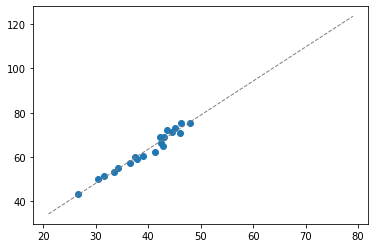

In [145]:
btc, atc, r_value, p_value, std_err = linregress(pcp4['pmean'],pcp4f['pmean'])
plt.scatter(pcp4['pmean'],pcp4f['pmean'])
plt.plot(np.arange(21,80), atc+np.arange(21,80)*btc, color='grey', linestyle='dashed', linewidth=1)

Percentage median 3.021977069661694
Percentage abs  1.1974012569036034
TCW hist/fut slope [0.5026969  0.49799113 0.49369456 0.48975603 0.48613259 0.48278787
 0.47969091 0.47681516 0.47413774 0.47163882 0.46930111 0.46710951
 0.46505074 0.46311307 0.46128612 0.45956067 0.45792849 0.45638221
 0.45491523 0.4535216  0.45219595 0.45093342 0.44972962 0.44858054
 0.44748253 0.44643225 0.44542667 0.44446299 0.44353864 0.44265127
 0.44179869 0.44097891 0.44019006 0.43943043 0.43869842 0.43799256
 0.43731146 0.43665385 0.43601852 0.43540438 0.43481037 0.43423553
 0.43367893 0.43313973 0.43261712 0.43211034 0.43161869 0.43114151
 0.43067815 0.43022803 0.4297906  0.42936531 0.42895167 0.42854922
 0.4281575  0.42777608 0.42740457 0.42704259 0.42668977]
Pmax percentage increase hist/fut [0.63808187 0.63345098 0.62922278 0.62534693 0.62178115 0.61848966
 0.61544198 0.612612   0.60997718 0.60751802 0.60521752 0.6030608
 0.60103478 0.59912795 0.59733008 0.59563208 0.59402588 0.59250421
 0.59106057 0.58

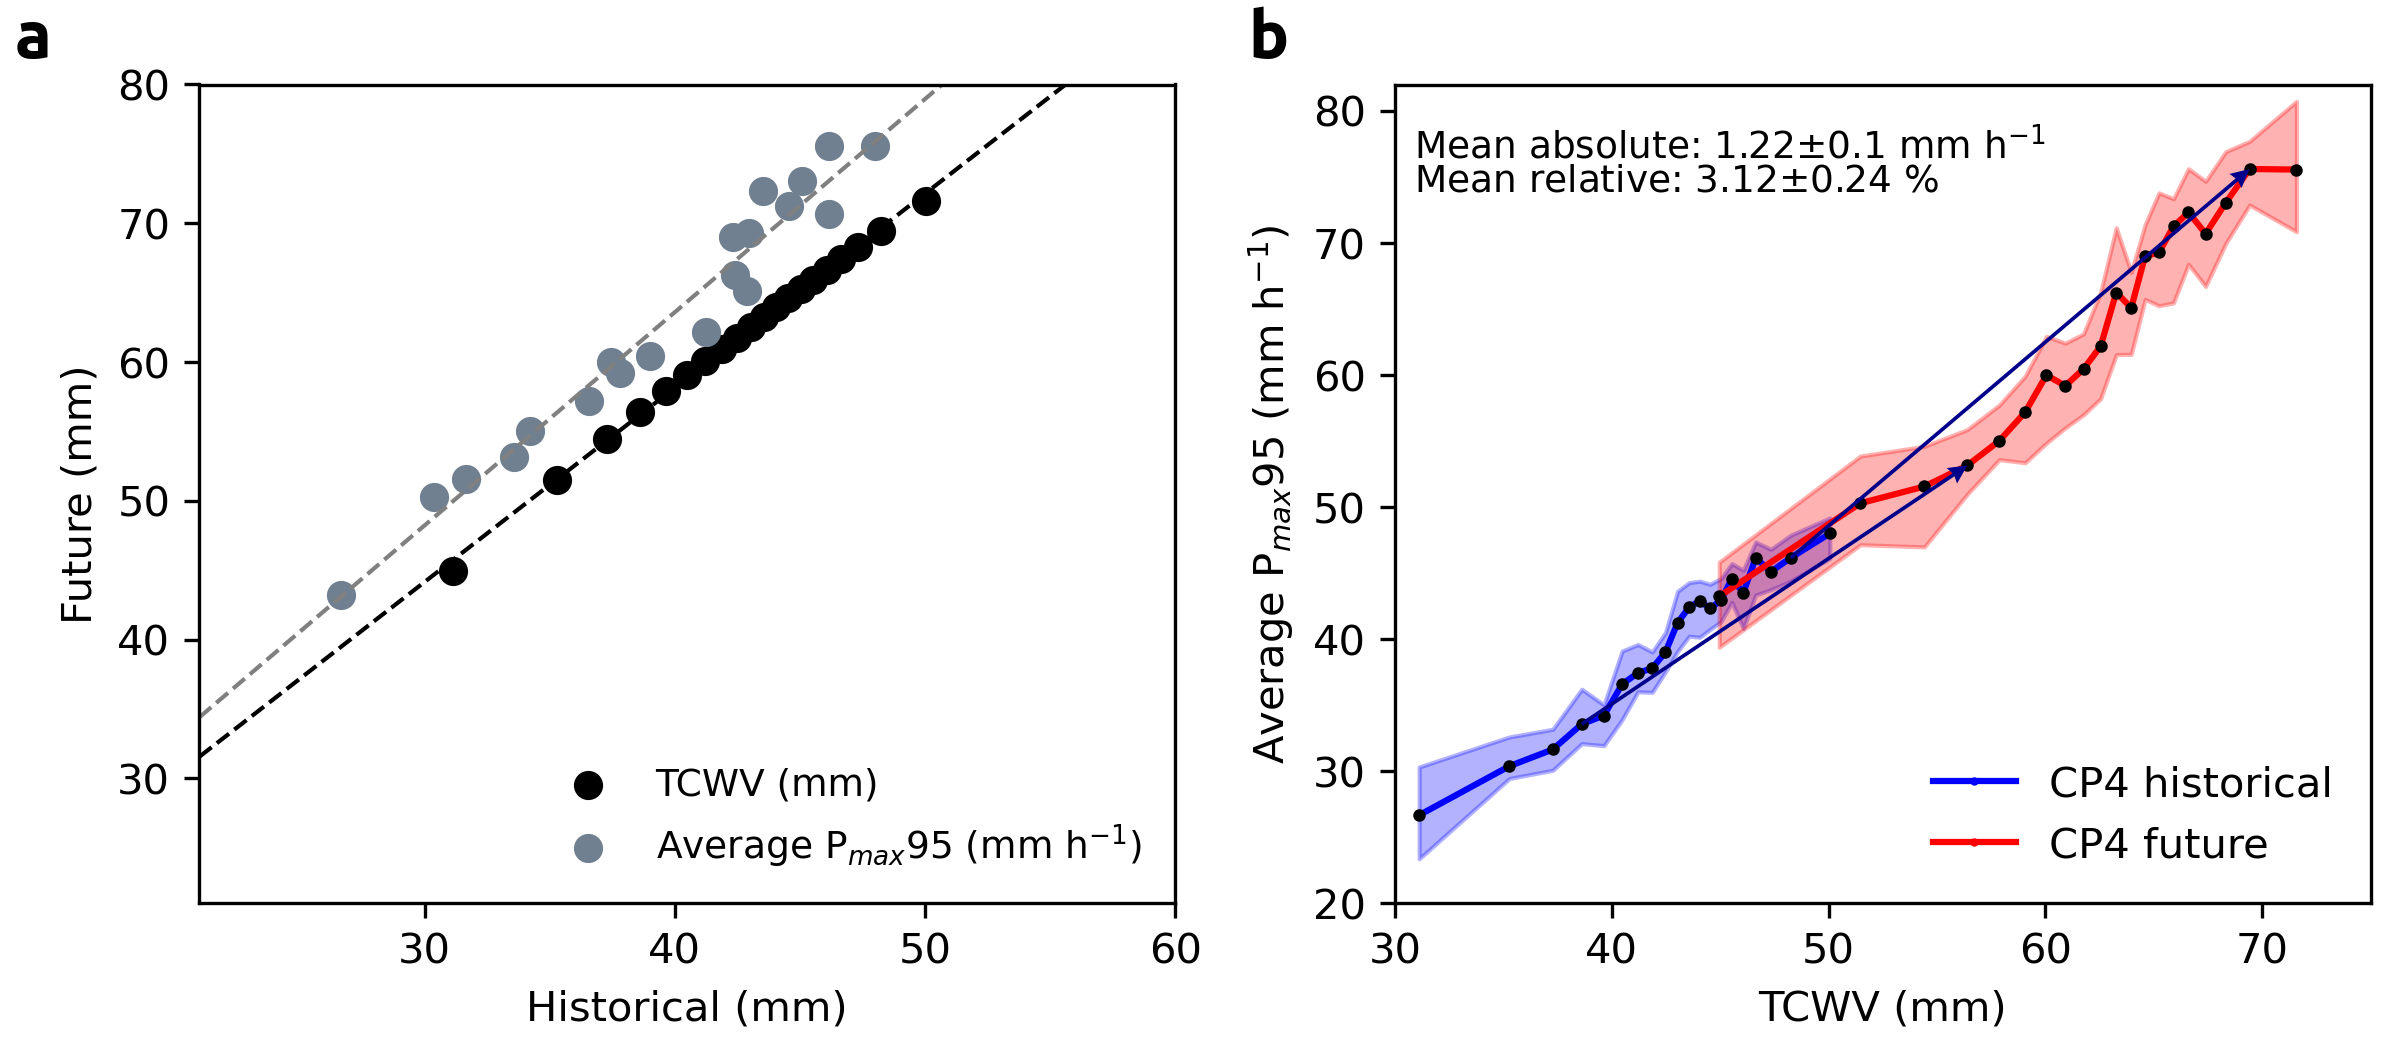

In [146]:
f = plt.figure(figsize=(8,3.5), dpi=300)

ax = f.add_subplot(122)

plt.fill_between(pcp4['rbins'],pcp4['p10'],pcp4['p90'], color='blue', alpha=0.3)
plt.fill_between(pcp4f['rbins'],pcp4f['p10'],pcp4f['p90'], color='red', alpha=0.3)
plt.plot(pcp4['rbins'],pcp4['pmean'], color='blue', marker='o', markersize=1, label=r'CP4 historical')
plt.plot(pcp4f['rbins'],pcp4f['pmean'], color='red', marker='o', markersize=1, label=r'CP4 future')
plt.plot(pcp4['rbins'],pcp4['pmean'], color='k', marker='o', linestyle='none',markersize=2)
plt.plot(pcp4f['rbins'],pcp4f['pmean'], color='k', marker='o', linestyle='none', markersize=2)

plt.quiver(pcp4['rbins'][3::15], pcp4['pmean'][3::15],(pcp4f['rbins']-pcp4['rbins'])[3::15],np.array((pcp4f['pmean'])-np.array(pcp4['pmean']))[3::15], angles='xy', scale_units='xy', scale=1, color='darkblue', width=0.0038, zorder=99, headwidth=5)
plt.xlim(30,75)
plt.legend(loc='lower right', frameon=False)
coll = []
abss = []

for ids, percs in enumerate(percents):
    ppabs = (np.array((pcp4f['pmean'][ids])-np.array(pcp4['pmean'][ids]))/((pcp4f['rbins'][ids]-pcp4['rbins'][ids])))
    pperc = (ppabs / pcp4['pmean'][ids])*100
    #plt.text(0.02, 0.96-ids*0.03,'p'+str(percs)+': ' + str(np.round(ppabs,2)) + ' | ' + str(np.round(pperc,2))+'%', transform=ax.transAxes, fontsize=7)  #(0.02, 0.08, 'ITD 0-line', color='turquoise', fontsize=12, transform=ax.transAxes)
    coll.append(pperc)
    abss.append(ppabs)

print('Percentage median', np.median(coll))
print('Percentage abs ', np.median(abss))

# plt.text(0.02, 0.11,'Mean relative: '+str(np.round(np.mean(coll),2))+'%', transform=ax.transAxes, fontsize=7)
# plt.text(0.02, 0.08,'Stddev relative: '+str(np.round(np.std(coll),2))+' %', transform=ax.transAxes, fontsize=7)
# plt.text(0.02, 0.05,'Mean absolute: '+str(np.round(np.mean(abss),2))+' mm', transform=ax.transAxes, fontsize=7)
# plt.text(0.02, 0.02,'Stddev absolute: '+str(np.round(np.std(abss),2))+' mm', transform=ax.transAxes, fontsize=7)

plt.text(0.02, 0.87,r'Mean relative: '+str(np.round(np.mean(coll),2))+'$\pm$'+str(np.round(np.std(coll)/2,2))+' %', transform=ax.transAxes, fontsize=9) # 0.83
#plt.text(0.02, 0.79,r'$\sigma$ relative: '+str(np.round(np.std(coll),2))+' %', transform=ax.transAxes, fontsize=9)
plt.text(0.02, 0.91,r'Mean absolute: '+str(np.round(np.mean(abss),2))+'$\pm$'+str(np.round(np.std(abss),2))+' mm h$^{-1}$', transform=ax.transAxes, fontsize=9)
#plt.text(0.02, 0.87,'$\sigma$ absolute: '+str(np.round(np.std(abss),2))+' mm h$^{-1}$', transform=ax.transAxes, fontsize=9)

plt.xlabel(r'TCWV (mm)')
plt.ylabel('Average P$_{max}$95 (mm h$^{-1}$)')

plt.ylim(20,82)

ax = f.add_subplot(121)
plt.scatter(pcp4['rbins'],pcp4f['rbins'], color='k', label='TCWV (mm)') #pmean
plt.scatter(pcp4['pmean'],pcp4f['pmean'], color='slategrey', label='Average P$_{max}$95 (mm h$^{-1}$)')
cmap=plt.get_cmap("Reds")

np.mean(abss)

b, a, r_value, p_value, std_err = linregress(pcp4['rbins'],pcp4f['rbins'])
btc, atc, r_value, p_value, std_err = linregress(pcp4['pmean'],pcp4f['pmean'])


pmax_increase = ((atc+np.arange(21,80)*btc)-np.arange(21,80))/np.arange(21,80)
tc_increase = ((a+np.arange(21,80)*b)-np.arange(21,80))/np.arange(21,80)
print('TCW hist/fut slope', tc_increase)
print('Pmax percentage increase hist/fut', pmax_increase)
print('TCW percentage increase hist/fut', tc_increase)
print('Pmax percentage increase hist/fut', pmax_increase)
print('increase ratio', pmax_increase/tc_increase)

precip_ratio = np.round(np.mean( (np.arange(21,80)*btc+atc)/ (np.arange(21,80)*b + a) ) , 2)
print('Precip ratio', precip_ratio)


plt.plot(np.arange(21,80), a+np.arange(21,80)*b, color='k', linestyle='dashed', linewidth=1)
plt.plot(np.arange(21,80), atc+np.arange(21,80)*btc, color='grey', linestyle='dashed', linewidth=1)
#plt.plot(np.arange(21,60), a*1.2+np.arange(21,60)*b*1.15, color='grey', linestyle='dashed', linewidth=1)


# plt.text(70,74,'+1K', fontsize=9)
# plt.text(36,77,'+10K', fontsize=9)
plt.ylabel('Future (mm)')
plt.xlabel('Historical (mm)')
plt.legend(loc='lower right', fontsize=9, frameon=False)
#plt.title('xCC(6.2% K$^{-1}$)$_{Pmax95}$: ' +str(cc_assumed) + r' || $\frac{\Delta TCW}{\Delta T2m}_{CP4}$: '+str(np.round(cc*100,2))+'% K$^{-1}$ ; Scaling$_{ratio}$'+ r'$\frac{Pmax95}{TCW}$: ' +str(precip_ratio), fontsize=8 ) #+str(total_pscaling)+'% K$^{-1}$' , fontsize=8)
#plt.title('Scaling$_{ratio}$'+ r'$\frac{Pmax95}{TCW}$: ' +str(precip_ratio), fontsize=8 )
#plt.text(0.02, 0.91,'Scaling$_{ratio}$'+ r'$\frac{Pmax95}{TCW}$: ' +str(precip_ratio), fontsize=9, transform=ax.transAxes) # 0.83
plt.xlim(21,60)
plt.ylim(21,80)

# ax11 = ax.twiny()
# ax11.plot()


pobs = obs_shear_tcwv
pcp4 = cp4_shear_tcwv
pcp4f = cp4f_shear_tcwv

# ax = f.add_subplot(133)
# #plt.plot(pobs['bins'],pobs['pmean'], '-bo', label=r'pobs | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(pobs['slope'],2)))
# #plt.fill_between(pobs['bins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
# plt.fill_between(pcp4['bins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
# plt.fill_between(pcp4f['bins'],pcp4f['p10'],pcp4f['p90'], color='red', alpha=0.3)
# plt.plot(pcp4['bins'],pcp4['pmean'], color='orange', marker='o', label=r'pcp4 | $\dfrac{\delta P}{\delta tcwv_{925}}$: ' + str(np.round(pcp4['slope'],2)))
# plt.plot(pcp4f['bins'],pcp4f['pmean'], '-ro', label=r'pcp4future | $\dfrac{\delta P}{\delta tcwv_{925}}$: ' + str(np.round(pcp4f['slope'],2)))
# #plt.plot(pobs['bins'],pobs['slope']*pobs['bins']+pobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
# plt.plot(pcp4['bins'],pcp4['slope']*pcp4['bins']+pcp4['intercept'], linestyle='dashed', color='k', linewidth=0.5)
# plt.plot(pcp4f['bins'],pcp4f['slope']*pcp4f['bins']+pcp4f['intercept'], linestyle='dashed', color='k', linewidth=0.5)
# for ids, pp in enumerate(np.arange(0,101,5)):
#     plt.axvline(pp, color='slategrey', linestyle='dashed', linewidth=0.5)
#     try:
#         ttext = np.round((np.array(pcp4f['pmean'])[ids]-np.array(pcp4['pmean'])[ids])/(np.array(pcp4['pmean'])[ids])*100,0).astype(int)
#         plt.text(pp+0.1, 87,str(ttext), fontsize=7)
#     except:
#         pass

# plt.xlabel('Percentiles: TCWV (%)')
# plt.ylabel('Average P$_{max}$95 (mm h$^{-1}$)')
# plt.title('Relative change in P$_{max}$95 per percentile (fut-hist)')
# #plt.ylim(10,80)
# plt.ylim(15,90)
# #plt.legend(loc='upper left')
# plt.ylim(15,90)

text = ['a', 'b']
plt.tight_layout()
plt.annotate(text[0], xy=(0.006, 0.93), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.52, 0.93), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)


plt.savefig(cnst.network_data + 'figs/ENDGAME/scatter_'+tag+'_OBS_CP4futureavg_'+ttag+'_TCWV2_monthly.png')

In [147]:
(np.arange(1,1000)+7*cc*np.arange(1,1000) ) / (np.arange(1,1000)+5.6*cc*np.arange(1,1000)) 

NameError: name 'cc' is not defined

In [ ]:
plt.plot(np.sin(np.linspace(0,30,300)))

In [ ]:
from scipy.signal import correlate

A = np.sin(np.linspace(0,30,300))
B = np.sin(np.linspace(0,30,300))
nsamples = A.size

# regularize datasets by subtracting mean and dividing by s.d.
A -= A.mean(); A /= A.std()
B -= B.mean(); B /= B.std()

# Put in an artificial time shift between the two datasets
time_shift = 8
A = np.roll(A, time_shift)

plt.plot(A)
plt.plot(B)

# Find cross-correlation
xcorr = correlate(A, B)

# delta time array to match xcorr
dt = np.arange(1-nsamples, nsamples)

recovered_time_shift = dt[xcorr.argmax()]
print('Added shift', time_shift)
print('Recovered shift', recovered_time_shift)